# Projeto MTR

0. Pegar o dataset de {DIR} disease (e possivelmente de airbnb)
1. Manipular os dados para deixá-los prontos para treinamento por modelos de ML 
2. Pesquisar e escolher os modelos para serem testados (de preferência modelos que sabemos ter erros correlacionados)
3. Treinar modelos (tentar achar os melhores hiperparâmetros, usar validação cruzada de 5 ou 10 folds)
4. Construir assessores (treinados para tentar prever o erro dos modelos) (também tentar achar melhores hiperparâmetros):

    4.1. Um assessor para cada modelo (RandomForestRegressor ou algum outro)
    
    4.2. Um assessor multi-target para todos os modelos (RegressorChains (outputs relacionados) **e** Single Target Method (outputs independentes))
    
    4.3. Um assessor para cada "família" ou grupo de modelos de ML com erros correlacionados (RegressorChains)

5. Coletar resultados e tirar conclusões para apresentar

## Imports e funções

In [1]:
from utils import *

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
import json
from torch import save, load

# Dataset

In [3]:
seed = 952811309#randint(0, 4294967295)
print(seed)

952811309


In [4]:
DIR = 'covid'

In [5]:
df = pd.read_csv(f'data/{DIR}/hosp1_v8 (1).csv') # 526 exemplos
df2 = pd.read_csv(f'data/{DIR}/hospital2 (2).csv').drop(columns=['creatino.fosfoquinase.cpk.plasma.ck',
                                                                  'troponina.i.plasma.troponina.i']) # 134 exemplos
df = pd.concat([df, df2])
print('Nº de instâncias:', len(df))
df.head()

Nº de instâncias: 660


sex   age  creatinina.plasma.creatinina  \
0  0.0  67.0                          1.17   
1  0.0  72.0                          0.90   
2  0.0  55.0                          1.02   
3  0.0  58.0                          0.90   
4  0.0  66.0                          1.98   

   dimero.d.plasma.dimeros.d.quantitativo  hemograma.eosinofilos.percentual  \
0                                   233.0                               0.0   
1                                  1475.0                               0.0   
2                                   439.0                               0.0   
3                                   215.0                               0.0   
4                                  1484.0                               0.5   

   hemograma.hemoglobina  hemograma.leucocitos  \
0                   12.5                3730.0   
1                   15.8                6610.0   
2                   14.6                3810.0   
3                   13.9               16190.0   
4                   12.8                4250.0   

   hemograma.linfocitos.percentual  hemograma.monocitos.percentual  \
0                             13.4                            11.3   
1                             20.3                             9.5   
2                             17.6                            12.3   
3                              4.2                             3.2   
4                             33.6                            12.7   

   hemograma.neutrofilos.percentual  hemograma.plaquetas  potassio.potassio  \
0                              75.0             182000.0                4.7   
1                              70.0             144000.0                4.7   
2                              69.8             111000.0                3.7   
3                              92.4             270000.0                4.9   
4                              52.5             135000.0                3.6   

   proteina.c.reativa.plasma.proteina.creativa  sodio.sodio  tgo.ast.tgo  \
0                                         5.86        140.0         77.0   
1                                         6.88        135.0         28.0   
2                                         3.35        137.0         41.0   
3                                         4.84        137.0         14.0   
4                                         7.07        139.0         60.0   

   tpg.alt.tgp  ureia.plasma.ureia  severity  
0        115.0                60.0         1  
1         13.0                39.0         1  
2         38.0                28.0         1  
3         29.0                49.0         1  
4         48.0                53.0         1

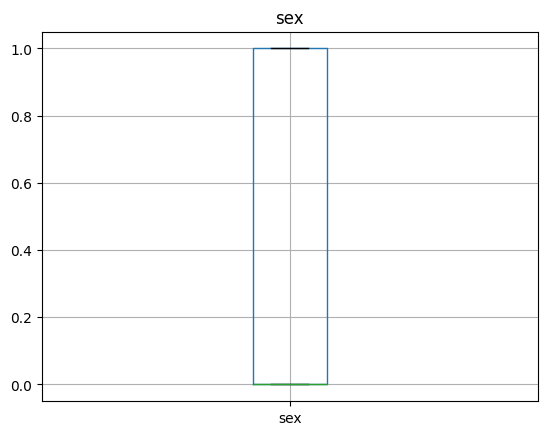

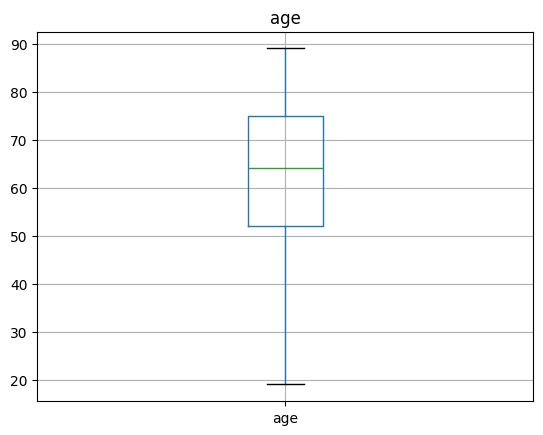

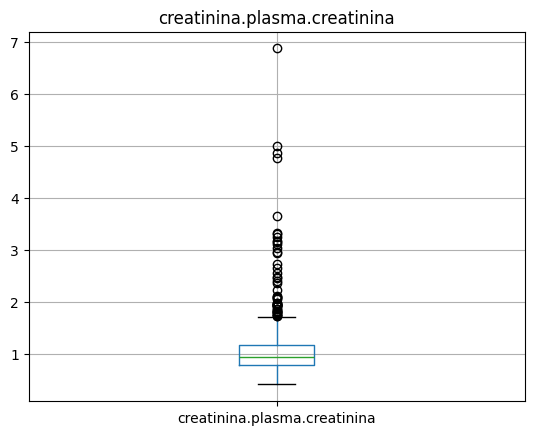

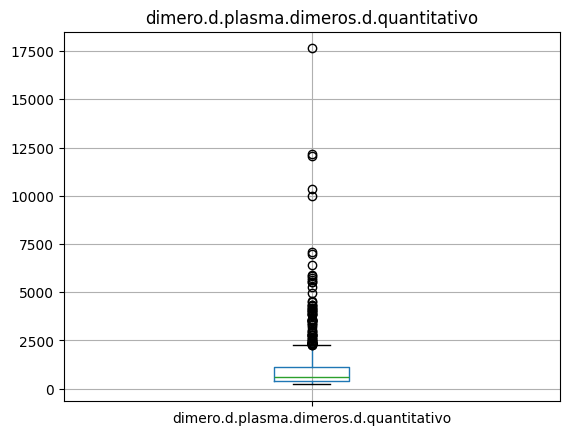

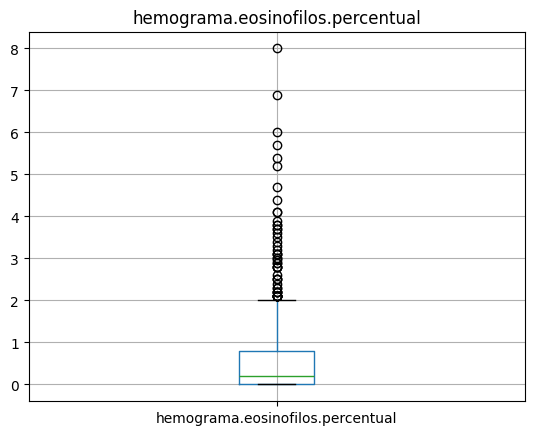

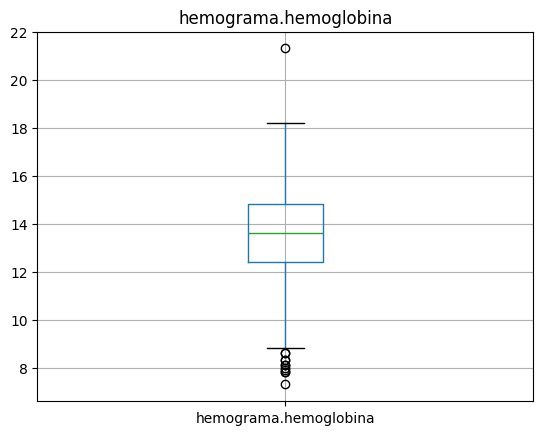

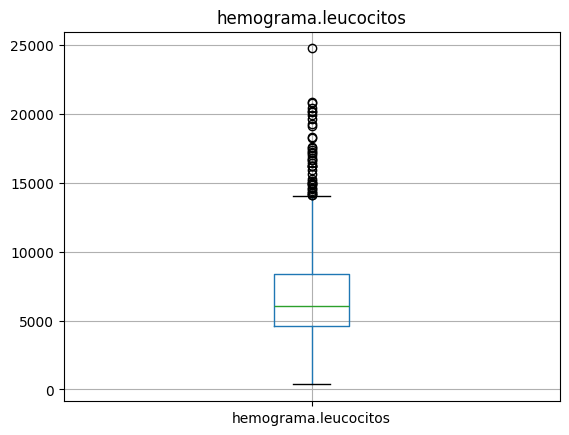

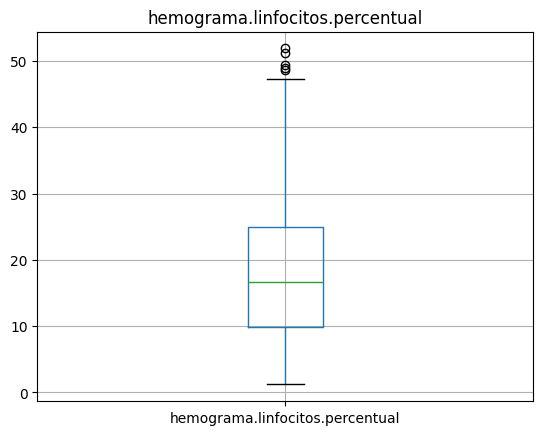

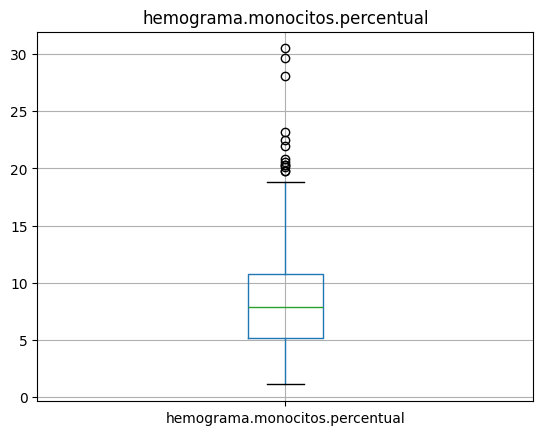

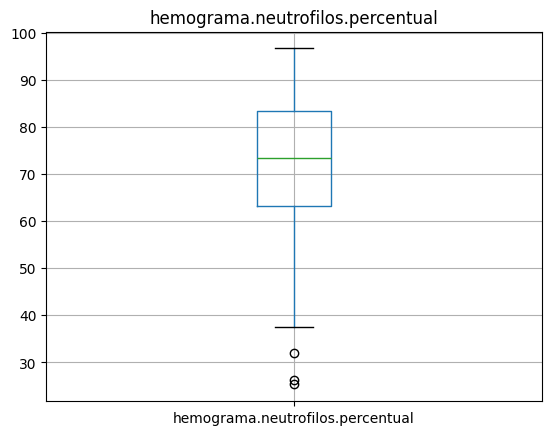

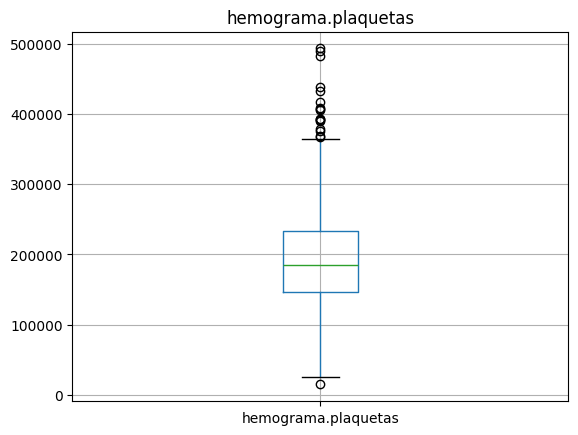

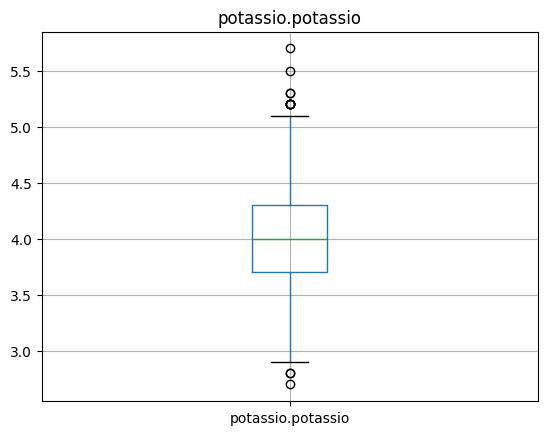

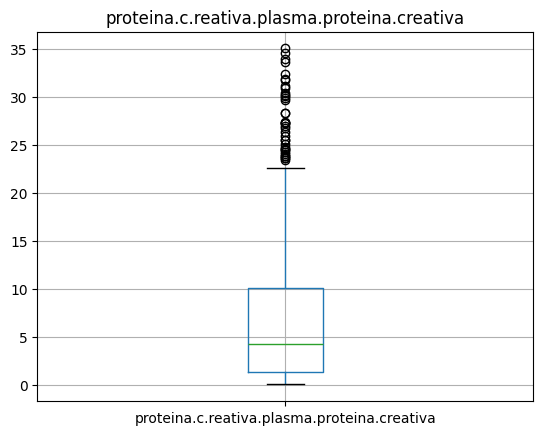

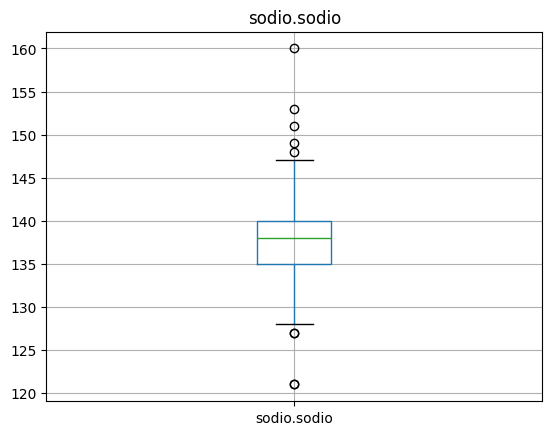

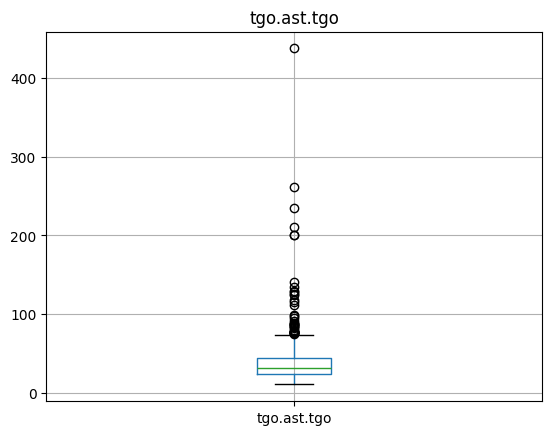

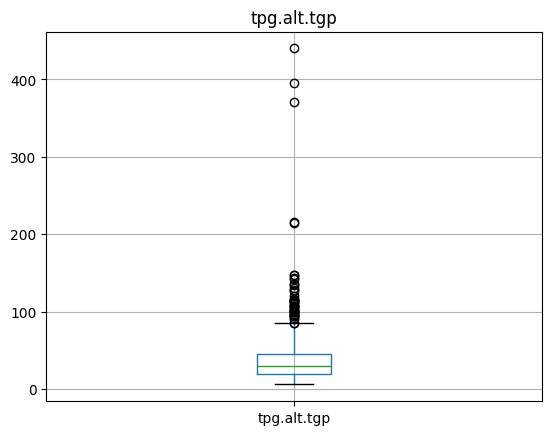

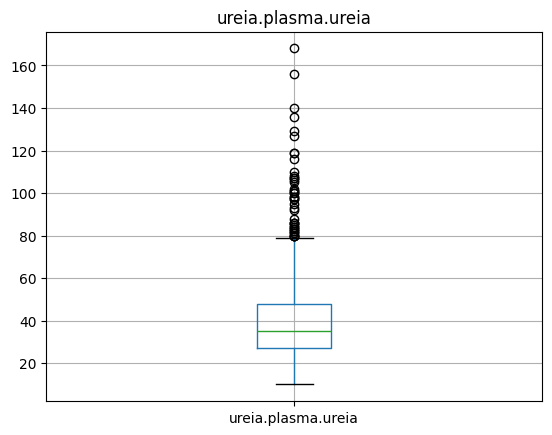

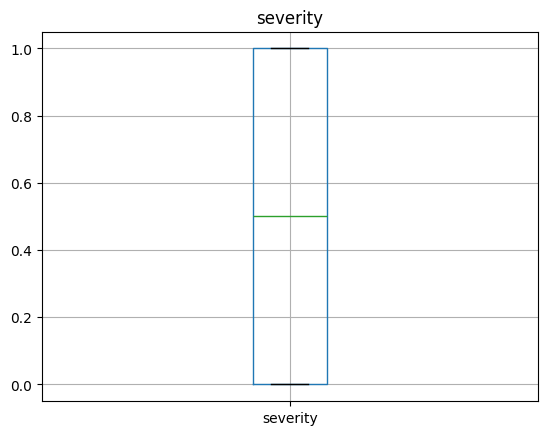

In [6]:
for col in df.columns:
    bp = df[[col]].boxplot()
    plt.title(col)
    plt.show(bp)

In [7]:
# Removing dastric outliers
df = df[(df['tpg.alt.tgp']<200) & (df['tgo.ast.tgo']<200) & (df['sodio.sodio']<155) & (df['dimero.d.plasma.dimeros.d.quantitativo']<7500)]
df

sex   age  creatinina.plasma.creatinina  \
0    0.0  67.0                          1.17   
1    0.0  72.0                          0.90   
2    0.0  55.0                          1.02   
3    0.0  58.0                          0.90   
4    0.0  66.0                          1.98   
..   ...   ...                           ...   
129  1.0  86.0                          0.90   
130  0.0  64.0                          4.77   
131  0.0  60.0                          1.41   
132  0.0  53.0                          1.05   
133  0.0  72.0                          1.66   

     dimero.d.plasma.dimeros.d.quantitativo  hemograma.eosinofilos.percentual  \
0                                     233.0                               0.0   
1                                    1475.0                               0.0   
2                                     439.0                               0.0   
3                                     215.0                               0.0   
4                                    1484.0                               0.5   
..                                      ...                               ...   
129                                  1689.0                               0.3   
130                                  3559.0                               0.0   
131                                  2118.0                               0.2   
132                                   585.0                               0.2   
133                                  2574.0                               0.1   

     hemograma.hemoglobina  hemograma.leucocitos  \
0                     12.5           3730.000000   
1                     15.8           6610.000000   
2                     14.6           3810.000000   
3                     13.9          16190.000000   
4                     12.8           4250.000000   
..                     ...                   ...   
129                    9.8           3930.000000   
130                   11.6           6914.464017   
131                   15.5          10610.000000   
132                   15.6           6130.000000   
133                   10.9          11410.000000   

     hemograma.linfocitos.percentual  hemograma.monocitos.percentual  \
0                               13.4                            11.3   
1                               20.3                             9.5   
2                               17.6                            12.3   
3                                4.2                             3.2   
4                               33.6                            12.7   
..                               ...                             ...   
129                             16.8                             7.9   
130                              2.1                             4.1   
131                              7.9                             5.5   
132                             10.1                             9.0   
133                              2.9                             7.9   

     hemograma.neutrofilos.percentual  hemograma.plaquetas  potassio.potassio  \
0                           75.000000             182000.0           4.700000   
1                           70.000000             144000.0           4.700000   
2                           69.800000             111000.0           3.700000   
3                           92.400000             270000.0           4.900000   
4                           52.500000             135000.0           3.600000   
..                                ...                  ...                ...   
129                         74.700000             176000.0           4.300000   
130                         74.809557             231000.0           4.043257   
131                         85.700000             259000.0           5.000000   
132                         80.500000             190000.0           3.600000   
133                         89.000000             182000.0           4.100

In [8]:
# 1/3 | 1/3 | 1/3
BASE_ASSESSOR_SPLIT = 0.3
BASE_TEST_SIZE = 0.5
cols = df.drop(columns=['severity']).columns

temp = df[df.severity==1]
train_pos, test_pos = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

temp = df[df.severity==0]
train_neg, test_neg = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

Xb_train, Xb_test, yb_train, yb_test = train_test_split(pd.concat([train_pos[cols], train_neg[cols]], ignore_index=True), # X
                                                            pd.concat([train_pos['severity'], train_neg['severity']], ignore_index=True), # y
                                                            test_size=BASE_TEST_SIZE, shuffle=True, random_state=seed)

In [9]:
scaler = StandardScaler()

Xb_train_norm = scaler.fit_transform(Xb_train, yb_train)
Xb_test_norm = scaler.transform(Xb_test)

In [10]:
Xa_test = pd.concat([test_pos[cols], test_neg[cols]], ignore_index=True)
ya_test = pd.concat([test_pos['severity'], test_neg['severity']], ignore_index=True)
Xa_test_norm = scaler.transform(Xa_test)

# Base Models

In [11]:
performs = {}
models_error = pd.DataFrame()
models = []

In [12]:
def register_performance(train_set:list|tuple, test_set:list|tuple, model, model_name:str, pdict:dict=performs):
    assert (len(train_set)==2) & (len(test_set)==2)

    # train_set
    pred = model.predict(train_set[0])

    pred_proba = model.predict_proba(train_set[0])
    minprob = [1-max(prob) for prob in pred_proba]

    metrics = compute_performance_metrics(train_set[1], pred, pred_proba[:,1])

    print('[Training]')
    print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
    print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
    print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
    pdict[model_name] = {'train': {'1-maxprob':minprob, 'accuracy':metrics[0], 
                                   'recall':metrics[1],
                                   'precision':metrics[2], 'f1':metrics[3],
                                   'auroc':metrics[4], 'aupr':metrics[5]}}
    # test_set
    pred = model.predict(test_set[0])
    
    pred_proba = model.predict_proba(test_set[0])
    minprob = [1-max(prob) for prob in pred_proba]

    metrics = compute_performance_metrics(test_set[1], pred, pred_proba[:,1])

    print('\n[Testing]')
    print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
    print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
    print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
    pdict[model_name]['test'] = {'1-maxprob':minprob, 'accuracy':metrics[0], 
                                 'recall':metrics[1],
                                 'precision':metrics[2], 'f1':metrics[3],
                                 'auroc':metrics[4], 'aupr':metrics[5]}
    return pdict

### Decision Tree

In [13]:
#dtree = DecisionTreeClassifier(random_state=seed)#.fit(Xb_train, yb_train)

dt_params = {'max_depth':[None,10,20,30], 
             'criterion':['gini','entropy','log_loss'],
             'min_samples_split':[2,5,10,20,40,60], 
             'min_samples_leaf':[1,2,10,30]}

g_search = GridSearchCV(DecisionTreeClassifier(random_state=seed), dt_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
dtree = g_search.best_estimator_

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 40}


c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [14]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), dtree, 'dtree')

[Training]

Accuracy:         0.8311
Recall:           0.8077
Precision:        0.8235
F1:               0.8155
AUROC:            0.8965
AUPR:             0.8622
1-maxProb média:  0.1689
1-maxProb dp:     0.1216

[Testing]

Accuracy:         0.6195
Recall:           0.5630
Precision:        0.6634
F1:               0.6091
AUROC:            0.6794
AUPR:             0.6734
1-maxProb média:  0.1763
1-maxProb dp:     0.1341


In [15]:
models_error['dtree'] = 1 - dtree.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models_error.head()

dtree
0  0.190476
1  0.285714
2  0.190476
3  0.500000
4  0.868421

In [16]:
models.append(dtree)

### Stochastic Gradient Descent
(SGD)

In [17]:
sgd_params = {
    'loss': ['log_loss', 'modified_huber'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [1e-4, 1e-3, 1e-2]
}

g_search = GridSearchCV(SGDClassifier(random_state=seed), sgd_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
sgd = g_search.best_estimator_

{'alpha': 0.01, 'loss': 'log_loss', 'penalty': 'l1'}


In [18]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), sgd, 'sgd')
models_error['sgd'] = 1 - sgd.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(sgd)

[Training]

Accuracy:         0.7689
Recall:           0.7212
Precision:        0.7653
F1:               0.7426
AUROC:            0.8090
AUPR:             0.7964
1-maxProb média:  0.2852
1-maxProb dp:     0.1311

[Testing]

Accuracy:         0.6283
Recall:           0.4958
Precision:        0.7108
F1:               0.5842
AUROC:            0.7102
AUPR:             0.7449
1-maxProb média:  0.2954
1-maxProb dp:     0.1328


### Logistic Regression

In [19]:
lr = LogisticRegression(random_state=seed, n_jobs=-1).fit(Xb_train_norm, yb_train)

lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

g_search = GridSearchCV(LogisticRegression(random_state=seed), lr_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
lr = g_search.best_estimator_

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


In [20]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), lr, 'lr')
models_error['lr'] = 1 - lr.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(lr)

[Training]

Accuracy:         0.7600
Recall:           0.7212
Precision:        0.7500
F1:               0.7353
AUROC:            0.8125
AUPR:             0.8036
1-maxProb média:  0.2924
1-maxProb dp:     0.1253

[Testing]

Accuracy:         0.6416
Recall:           0.5042
Precision:        0.7317
F1:               0.5970
AUROC:            0.7183
AUPR:             0.7609
1-maxProb média:  0.2982
1-maxProb dp:     0.1290


### K-Nearest Neighbors

(KNN)

In [21]:
#knn = KNeighborsClassifier(n_jobs=-1).fit(Xb_train_norm, yb_train)

knn_params = {
    'n_neighbors': list(range(3,21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

g_search = GridSearchCV(KNeighborsClassifier(), knn_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
knn = g_search.best_estimator_

{'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}


In [22]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), knn, 'knn')
models_error['knn'] = 1 - knn.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(knn)

c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0000
1-maxProb dp:     0.0000

[Testing]

Accuracy:         0.5752
Recall:           0.2773
Precision:        0.7674
F1:               0.4074
AUROC:            0.7360
AUPR:             0.7576
1-maxProb média:  0.3260
1-maxProb dp:     0.1164


### Support Vector Machine - Linear
(SVM)

In [23]:
#svm_linear = SVC(kernel='linear', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_linear_params = {
    'C': [0.1, 1, 10]
}

g_search = GridSearchCV(SVC(kernel='linear', probability=True, random_state=seed), svm_linear_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_linear = g_search.best_estimator_

{'C': 1}


In [24]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_linear , 'svm_linear')
models_error['svm_linear'] = 1 - svm_linear.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_linear)

[Training]

Accuracy:         0.7644
Recall:           0.7019
Precision:        0.7684
F1:               0.7337
AUROC:            0.8101
AUPR:             0.7862
1-maxProb média:  0.3469
1-maxProb dp:     0.0965

[Testing]

Accuracy:         0.6460
Recall:           0.4790
Precision:        0.7600
F1:               0.5876
AUROC:            0.7136
AUPR:             0.7549
1-maxProb média:  0.3420
1-maxProb dp:     0.0995


### Support Vector Machine - Polynomial
(SVM)

In [25]:
#svm_poly = SVC(kernel='poly', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_poly_params = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

g_search = GridSearchCV(SVC(kernel='poly', probability=True, random_state=seed), svm_poly_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_poly = g_search.best_estimator_

{'C': 10, 'degree': 3, 'gamma': 'auto'}


In [26]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_poly, 'svm_poly')
models_error['svm_poly'] = 1 - svm_poly.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_poly)

[Training]

Accuracy:         0.9422
Recall:           0.8750
Precision:        1.0000
F1:               0.9333
AUROC:            0.9976
AUPR:             0.9974
1-maxProb média:  0.3956
1-maxProb dp:     0.0736

[Testing]

Accuracy:         0.5796
Recall:           0.3866
Precision:        0.6765
F1:               0.4920
AUROC:            0.6695
AUPR:             0.7217
1-maxProb média:  0.3945
1-maxProb dp:     0.0919


### Support Vector Machine - RBF
(SVM)

In [27]:
#svm_rbf = SVC(kernel='rbf', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_rbf_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

g_search = GridSearchCV(SVC(kernel='rbf', probability=True, random_state=seed), svm_rbf_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_rbf = g_search.best_estimator_

{'C': 1, 'gamma': 'scale'}


In [28]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_rbf, 'svm_rbf')
models_error['svm_rbf'] = 1 - svm_rbf.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(svm_rbf)

[Training]

Accuracy:         0.8444
Recall:           0.7692
Precision:        0.8791
F1:               0.8205
AUROC:            0.9165
AUPR:             0.9188
1-maxProb média:  0.2748
1-maxProb dp:     0.0985

[Testing]

Accuracy:         0.6770
Recall:           0.5798
Precision:        0.7500
F1:               0.6540
AUROC:            0.7316
AUPR:             0.7430
1-maxProb média:  0.3137
1-maxProb dp:     0.1069


### Multi-Layer Perceptron
(MLP)

In [29]:
#mlp = MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed).fit(Xb_train_norm, yb_train)

mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001]
}

g_search = GridSearchCV(MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed), mlp_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
mlp = g_search.best_estimator_

{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'solver': 'sgd'}


c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [30]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), mlp, 'mlp')
models_error['mlp'] = 1 - mlp.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(mlp)

[Training]

Accuracy:         0.8356
Recall:           0.7981
Precision:        0.8384
F1:               0.8177
AUROC:            0.9094
AUPR:             0.9096
1-maxProb média:  0.2392
1-maxProb dp:     0.1429

[Testing]

Accuracy:         0.6726
Recall:           0.5630
Precision:        0.7528
F1:               0.6442
AUROC:            0.7354
AUPR:             0.7733
1-maxProb média:  0.2509
1-maxProb dp:     0.1514


### Kolmogorov-Arnold Network
(KAN)

In [31]:
kan_cv = int(input('Rodar CV da KAN? (0-Não / 1-Sim): '))

In [32]:
'''dataset = {'train_input': Xb_train_norm,
           'train_label': yb_train,
           'test_input': Xb_test_norm,
           'test_label': yb_test}'''

#best_width = [13,5,5,2]
INP_SIZE = Xb_train_norm.shape[1]
kan_params = {'width': [[INP_SIZE,2,2,2], [INP_SIZE,3,2], [INP_SIZE,20,2]],
              'grid': [3, 6, 8],
              'lr': [0.0001, 0.001, 0.01],
              'lamb': [0.005, 0.1]}

if(kan_cv):
    best_score = 0
    for w in kan_params['width']:
        for g in kan_params['grid']:
            for lr in kan_params['lr']:
                for l in kan_params['lamb']:
                    score = cross_val_score(KANClassifier(w, grid=g, lr=lr, lamb=l, random_state=seed, grid_eps=1, steps=15), X=Xb_train_norm, y=yb_train, cv=5, error_score=0).mean()
                    if(score > best_score):
                        best_score = score
                        best_width = w
                        best_grid = g
                        best_lr = lr
                        best_lamb = l
    kanet = KANClassifier(best_width, grid=best_grid, lr=best_lr, lamb=best_lamb, random_state=seed, grid_eps=1, steps=15).fit(Xb_train_norm, yb_train)
    with open(f'kan_params/{DIR}.json', 'w') as f:
        json.dump({'width': best_width, 'grid': best_grid, 'lr': best_lr, 'lamb': best_lamb}, f)
        #joblib.dump(kanet.state_dict(), 'kan_params/{DIR}.pkl')
    save(kanet.state_dict(), f'kan_params/{DIR}.pt')
else:
    with open(f'kan_params/{DIR}.json', 'r') as f:
        kan_dict = json.load(f)
    best_width = kan_dict['width']
    best_grid = kan_dict['grid']
    best_lr = kan_dict['lr']
    best_lamb = kan_dict['lamb']
    
    kanet = KANClassifier(best_width, grid=best_grid, lr=best_lr, lamb=best_lamb, random_state=seed, grid_eps=1, steps=15)
    kanet.load_state_dict(load(f'kan_params/{DIR}.pt', weights_only=True))

print('width: {},\ngrid: {},\nlr: {},\nlamb: {}'.format(best_width, best_grid, best_lr, best_lamb))

width: [[17, 0], [20, 0], [2, 0]],
grid: 8,
lr: 0.001,
lamb: 0.005


In [33]:
performs = register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), kanet, 'kan')
models_error['kan'] = 1 - kanet.predict_proba(Xb_test_norm)[np.arange(len(Xb_test_norm)), yb_test]
models.append(kanet)

[Training]

Accuracy:         0.9333
Recall:           0.9135
Precision:        0.9406
F1:               0.9268
AUROC:            0.9817
AUPR:             0.9823
1-maxProb média:  0.1291
1-maxProb dp:     0.1387

[Testing]

Accuracy:         0.6195
Recall:           0.6387
Precision:        0.6387
F1:               0.6387
AUROC:            0.6907
AUPR:             0.7246
1-maxProb média:  0.1446
1-maxProb dp:     0.1464


### Random Forest

In [34]:
#rforest = RandomForestClassifier(random_state=seed, n_jobs=-1).fit(Xb_train, yb_train)

parameters = {'max_depth':[None,10,20,30], 
              'criterion':['gini','entropy','log_loss'],
              'min_samples_split':[2,5,10,20,40,60], 
              'min_samples_leaf':[1,2,10,30],
              'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(RandomForestClassifier(random_state=seed), parameters, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
rforest = g_search.best_estimator_

{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 40, 'n_estimators': 100}


In [35]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), rforest, 'rforest')
models_error['rforest'] = 1 - rforest.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(rforest)

[Training]

Accuracy:         0.8178
Recall:           0.7788
Precision:        0.8182
F1:               0.7980
AUROC:            0.8887
AUPR:             0.8750
1-maxProb média:  0.3204
1-maxProb dp:     0.0978

[Testing]

Accuracy:         0.6416
Recall:           0.5462
Precision:        0.7065
F1:               0.6161
AUROC:            0.7311
AUPR:             0.7514
1-maxProb média:  0.3436
1-maxProb dp:     0.0991


### Gradient Boosting

In [36]:
#gb = GradientBoostingClassifier(random_state=seed).fit(Xb_train, yb_train)

gb_params = {'max_depth':[None,10,20,30], 
             'criterion':['friedman_mse', 'squared_error'],
             'min_samples_split':[2,5,10,20,40,60], 
             'learning_rate': [0.01, 0.05, 0.1],
             'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(GradientBoostingClassifier(random_state=seed), gb_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
gb = g_search.best_estimator_

{'criterion': 'friedman_mse', 'learning_rate': 0.05, 'max_depth': 10, 'min_samples_split': 60, 'n_estimators': 50}


In [37]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), gb, 'gb')
models_error['gb'] = 1 - gb.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(gb)

[Training]

Accuracy:         0.9467
Recall:           0.9327
Precision:        0.9510
F1:               0.9417
AUROC:            0.9928
AUPR:             0.9916
1-maxProb média:  0.2264
1-maxProb dp:     0.1151

[Testing]

Accuracy:         0.6416
Recall:           0.5378
Precision:        0.7111
F1:               0.6124
AUROC:            0.7150
AUPR:             0.7649
1-maxProb média:  0.2825
1-maxProb dp:     0.1183


### AdaBoost

In [38]:
#adab = AdaBoostClassifier(random_state=seed).fit(Xb_train, yb_train)

adab_params = {'learning_rate': [0.01, 0.05, 0.1, 1],
               'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(AdaBoostClassifier(random_state=seed), adab_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
adab = g_search.best_estimator_

{'learning_rate': 0.05, 'n_estimators': 150}


c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [39]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), adab, 'adab')
models_error['adab'] = 1 - adab.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test]
models.append(adab)

[Training]

Accuracy:         0.8178
Recall:           0.7212
Precision:        0.8621
F1:               0.7853
AUROC:            0.9063
AUPR:             0.9054
1-maxProb média:  0.4533
1-maxProb dp:     0.0407

[Testing]

Accuracy:         0.6549
Recall:           0.5462
Precision:        0.7303
F1:               0.6250
AUROC:            0.7361
AUPR:             0.7522
1-maxProb média:  0.4607
1-maxProb dp:     0.0310


### XGBoost

In [40]:
#xgb = XGBClassifier(random_state=seed).fit(Xb_train, yb_train)

xgb_params = {
    'n_estimators': [20,50,100,150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [None,5,10,20,30],
    'gamma': [None, 0.25, 0.5]
}

g_search = GridSearchCV(XGBClassifier(random_state=seed), xgb_params, n_jobs=1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
xgb = g_search.best_estimator_

{'gamma': 0.25, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 100}


In [41]:
performs = register_performance((Xb_train, yb_train), (Xb_test, yb_test), xgb, 'xgb')
models_error['xgb'] = 1 - xgb.predict_proba(Xb_test)[np.arange(len(Xb_test)), yb_test] #xgb.predict(Xb_test) != yb_test 
models.append(xgb)

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0972
1-maxProb dp:     0.0605

[Testing]

Accuracy:         0.6283
Recall:           0.5042
Precision:        0.7059
F1:               0.5882
AUROC:            0.7172
AUPR:             0.7449
1-maxProb média:  0.2128
1-maxProb dp:     0.1406


## Análise de Correlações

In [42]:
groups = {}
model_names = list(performs.keys())

In [43]:
pred_corrls = pd.DataFrame(columns=models_error.columns, index=models_error.columns, dtype=float)

ya_train = pd.DataFrame(columns=model_names, index=yb_test.index)

for i in range(len(models)):
    
    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict_proba(Xb_test)
    else:
        y_pred = models[i].predict_proba(Xb_test_norm)

    ya_train.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), yb_test]


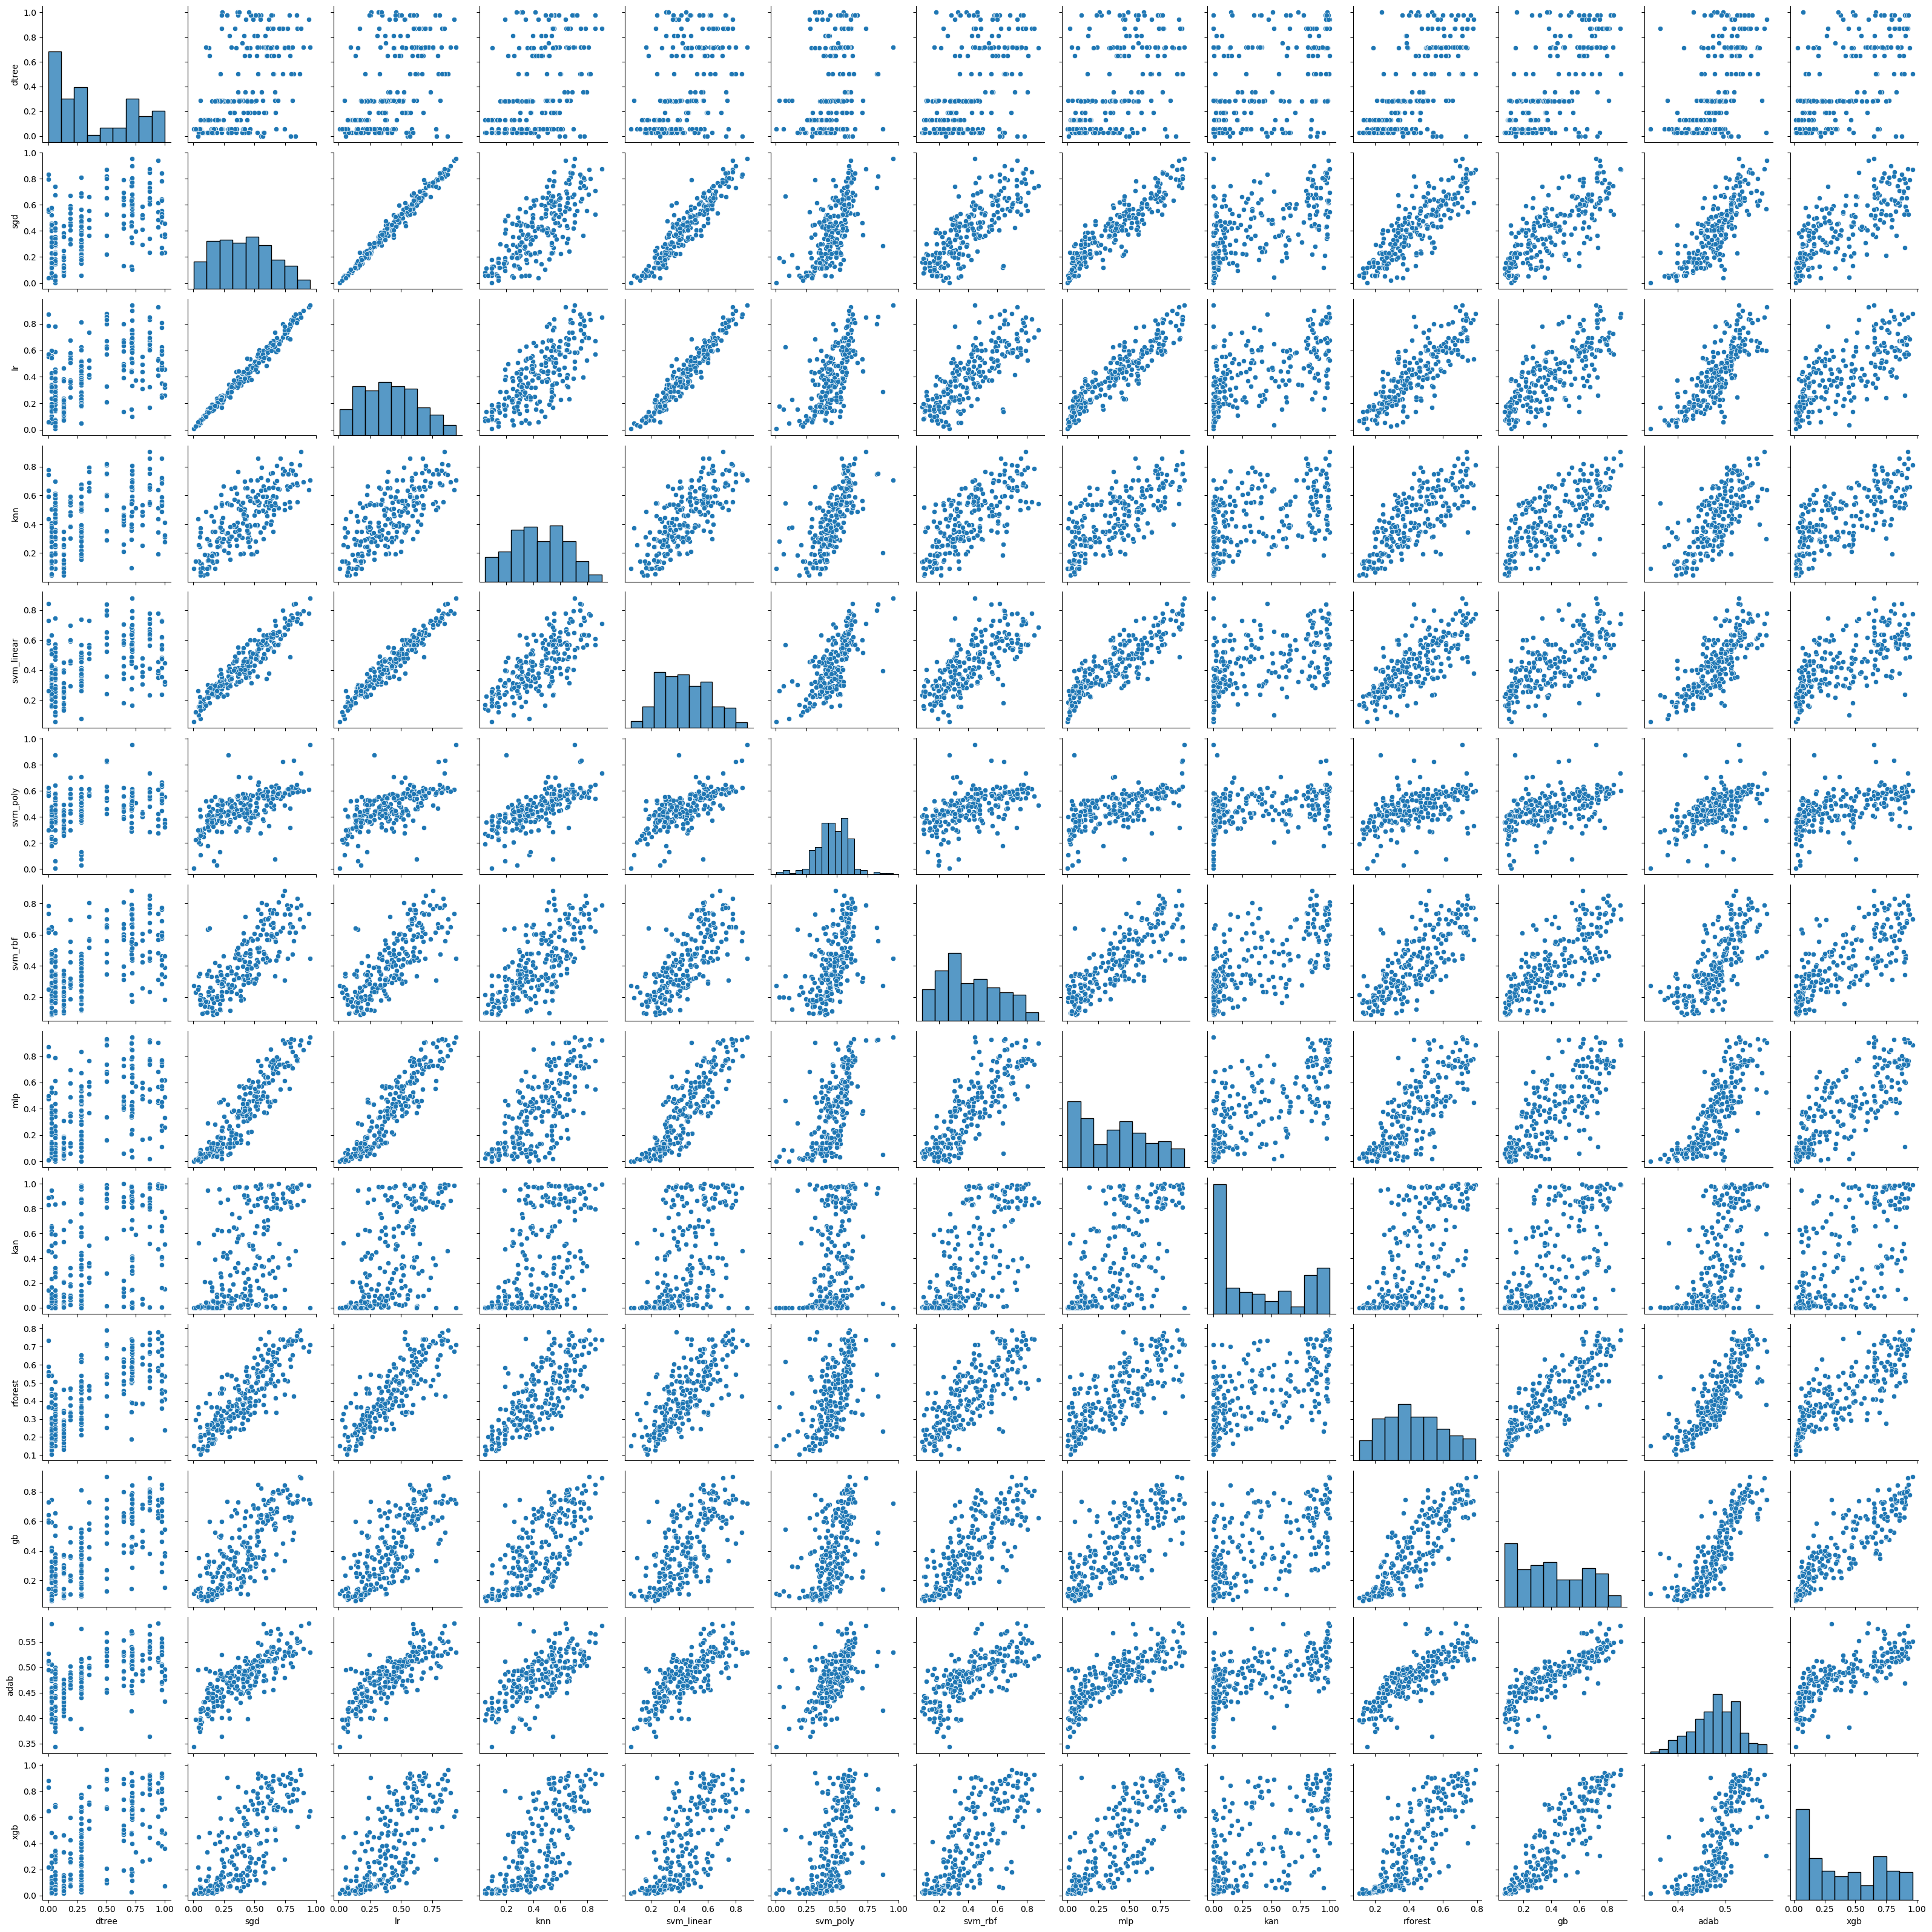

In [44]:
sns.pairplot(models_error)
plt.show()

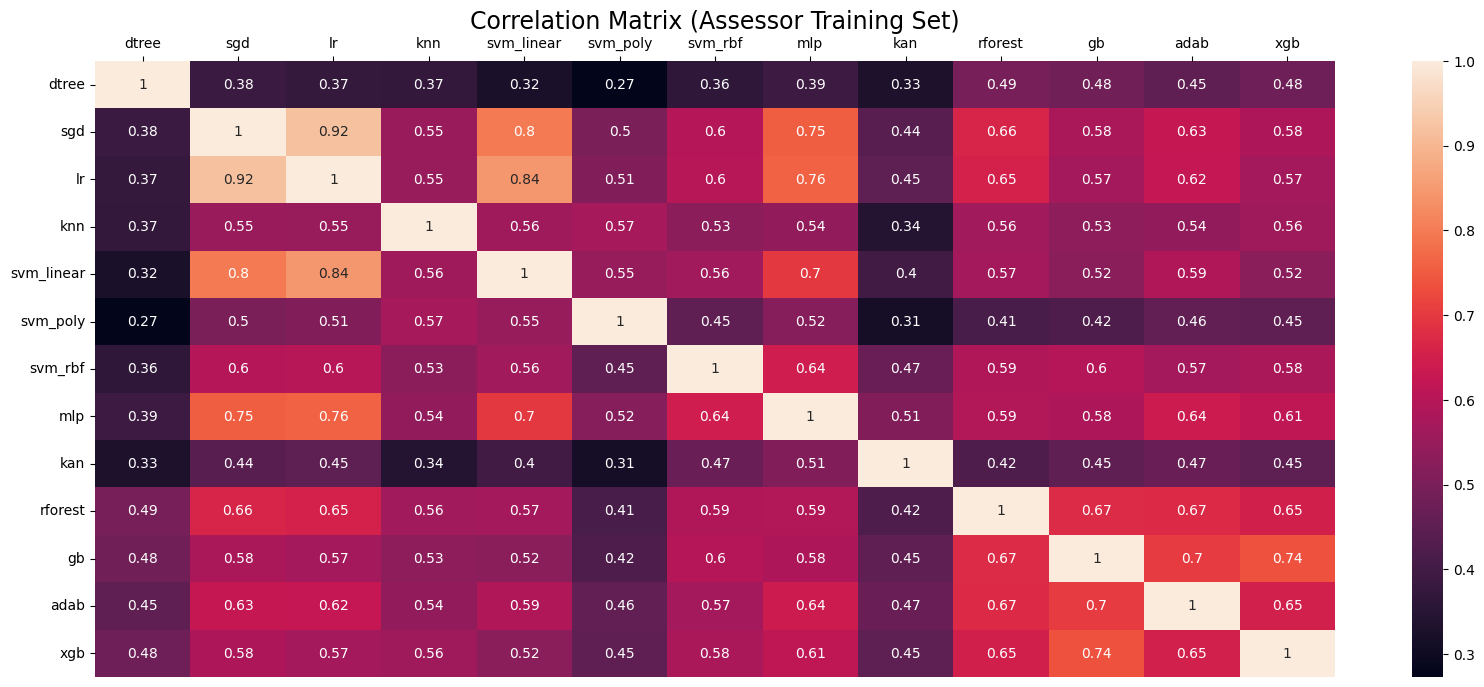

            corr
count  78.000000
mean    0.542366
std     0.123981
min     0.273123
25%     0.454701
50%     0.551583
75%     0.600936
max     0.918112


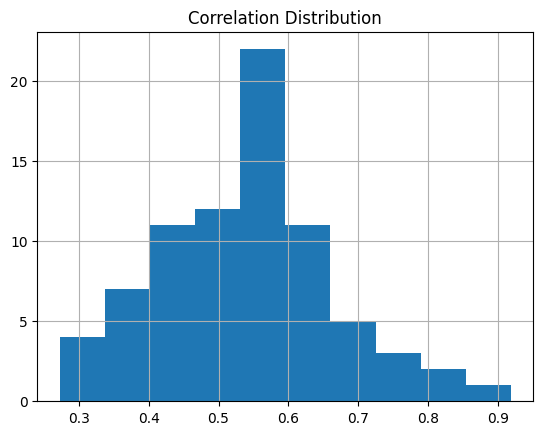

[Saved image "cm_atrain.eps"]
[Saved image "cd_atrain.eps"]


In [45]:
pred_corrls = models_error.corr('kendall')
plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (Assessor Training Set)', fontsize=17)
hm = sns.heatmap(pred_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

corrls_values = corrlArray(pred_corrls)

print(corrls_values[['corr']].describe())

plt.title('Correlation Distribution')
hg = corrls_values['corr'].hist()
plt.show(hg)

save2figs(hm, hg, DIR)

Se for pegar um grupo para analisar, tentar usar como a correlação mínima entre previsões o 3º quantil, o que daria por volta de  (no caso atual)

In [46]:
MIN_SCORE = 0.645 #corrls_values['corr'].quantile(0.75)

print('Min_score:', MIN_SCORE)

groups['true_assessor_train'] = group_search(pred_corrls, MIN_SCORE)
groups['true_assessor_train']

Min_score: 0.645


[['sgd', 'mlp', 'lr', 'svm_linear'],
 ['knn'],
 ['dtree'],
 ['svm_poly'],
 ['kan'],
 ['xgb', 'gb', 'rforest', 'adab'],
 ['sgd', 'lr', 'rforest'],
 ['svm_rbf']]

fazer com que todos os modelos do grupo tenham uma correlação acima do score mínimo entre todos eles? Ou fazer com que o próximo modelo encontrado do grupo tenha uma correlação acima do mínimo com o modelo mais recente?

(provavelmente o primeiro)

# Assessors

In [47]:
Xa_train = Xb_test.copy()
ya_train_tgt = yb_test
ya_train = models_error.copy()

ya_train.head()

dtree       sgd        lr       knn  svm_linear  svm_poly   svm_rbf  \
0  0.190476  0.326211  0.317721  0.385279    0.447217  0.448780  0.261395   
1  0.285714  0.244484  0.230082  0.665772    0.316237  0.514166  0.463834   
2  0.190476  0.592933  0.552197  0.485749    0.598992  0.616811  0.425044   
3  0.500000  0.869155  0.875341  0.813637    0.776030  0.601459  0.699032   
4  0.868421  0.631041  0.615283  0.752580    0.605284  0.552642  0.738871   

        mlp       kan   rforest        gb      adab       xgb  
0  0.114766  0.189937  0.329469  0.236571  0.468321  0.119452  
1  0.470305  0.441541  0.466102  0.377075  0.479857  0.247849  
2  0.594399  0.103896  0.337260  0.216889  0.474662  0.322782  
3  0.884389  0.991030  0.790703  0.900912  0.551558  0.964818  
4  0.757483  0.798998  0.569722  0.686374  0.533533  0.830849

In [48]:
ya_test = pd.DataFrame(ya_test)

for i in range(len(models)):
    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict_proba(Xa_test)
    else:
        y_pred = models[i].predict_proba(Xa_test_norm)
        
    ya_test.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), ya_test['severity']]

ya_test_tgt = ya_test['severity']
ya_test = ya_test.drop(columns=['severity'])
ya_test.head()

dtree       sgd        lr       knn  svm_linear  svm_poly   svm_rbf  \
0  0.190476  0.285953  0.354128  0.396356    0.485046  0.518594  0.228260   
1  0.057143  0.232606  0.235379  0.411203    0.361948  0.492017  0.336863   
2  0.717949  0.412710  0.357899  0.568290    0.394412  0.523740  0.500000   
3  0.868421  0.719079  0.665740  0.857670    0.599440  0.558994  0.811594   
4  0.190476  0.527024  0.517484  0.676954    0.549655  0.554389  0.526307   

        mlp       kan   rforest        gb      adab       xgb  
0  0.223247  0.000489  0.218551  0.190790  0.456058  0.030216  
1  0.109068  0.081058  0.242400  0.260972  0.460753  0.086179  
2  0.295608  0.032182  0.650053  0.494326  0.511796  0.653103  
3  0.839491  0.950252  0.780465  0.861225  0.552613  0.968887  
4  0.578856  0.144380  0.451283  0.206187  0.483876  0.161942

#### Análise de correlações

Conjunto de Treinamento:

O conjunto de teste dos modelos base já é o conjunto de treinamento dos assessores.

Conjunto de Teste:

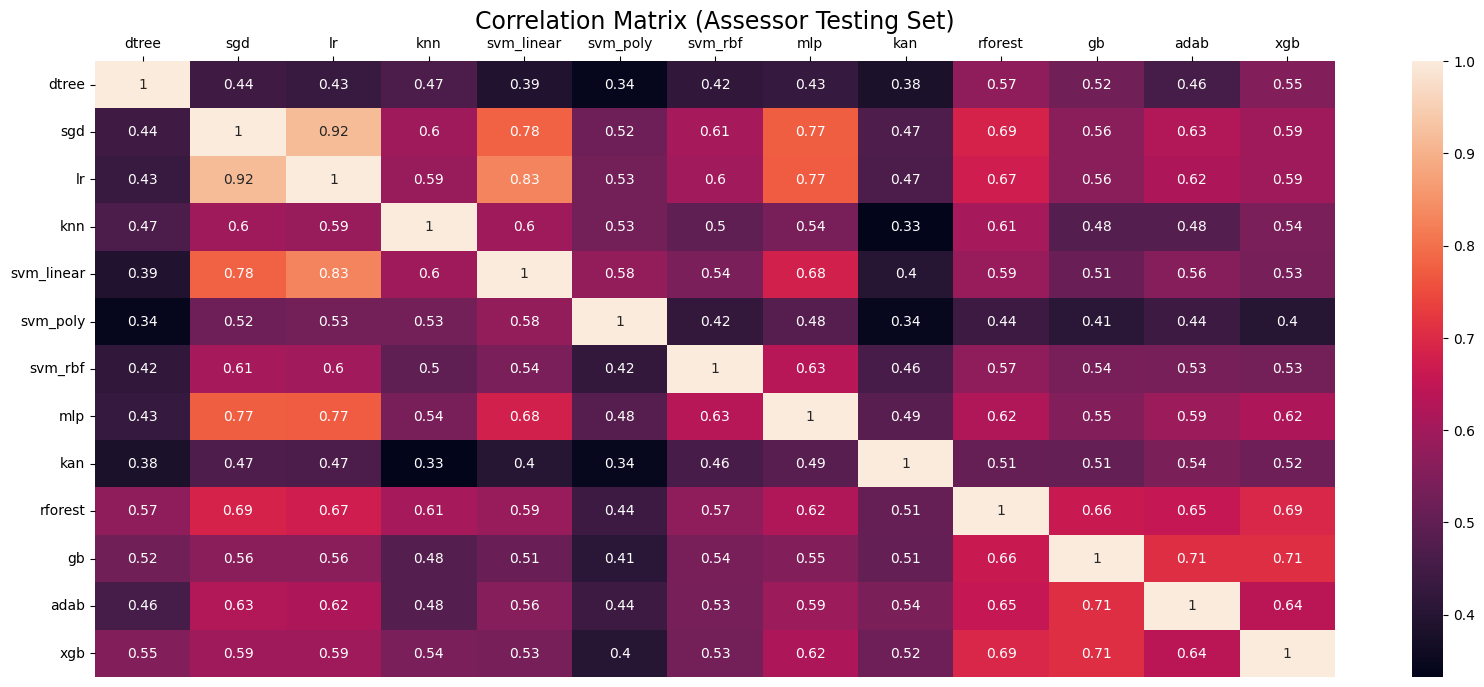

count    78.000000
mean      0.551061
std       0.113178
min       0.332382
25%       0.472271
50%       0.538456
75%       0.606660
max       0.916257
Name: corr, dtype: float64


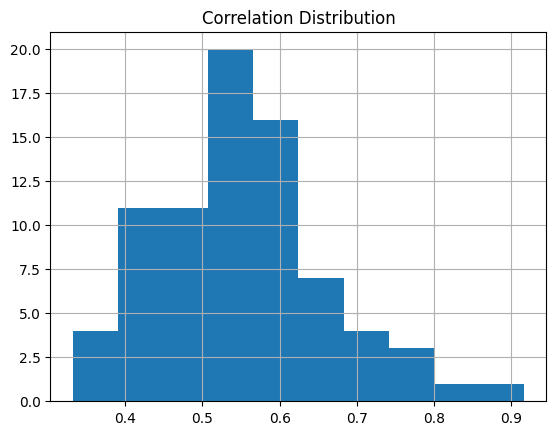

[Saved image "cm_atest.eps"]
[Saved image "cd_atest.eps"]


In [49]:
pred_corrls2 = ya_test.corr('kendall')
plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (Assessor Testing Set)', fontsize=17)
hm = sns.heatmap(pred_corrls2, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

corrls_values2 = corrlArray(pred_corrls2)['corr']
print(corrls_values2.describe())

plt.title('Correlation Distribution')
hg = corrls_values2.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [50]:
groups['true_assessor_test'] = group_search(pred_corrls2, MIN_SCORE)
groups['true_assessor_test']

[['sgd', 'mlp', 'lr', 'svm_linear'],
 ['knn'],
 ['dtree'],
 ['svm_poly'],
 ['kan'],
 ['sgd', 'lr', 'rforest'],
 ['xgb', 'gb', 'rforest'],
 ['gb', 'rforest', 'adab'],
 ['svm_rbf']]

Diferença entre correlações do conjnuto de teste e de treinamento:
MSE: 0.0015
NMSE: 0.0383
MAE: 0.0308
NMSE: 0.0955
Desvio Padrão: 0.0376


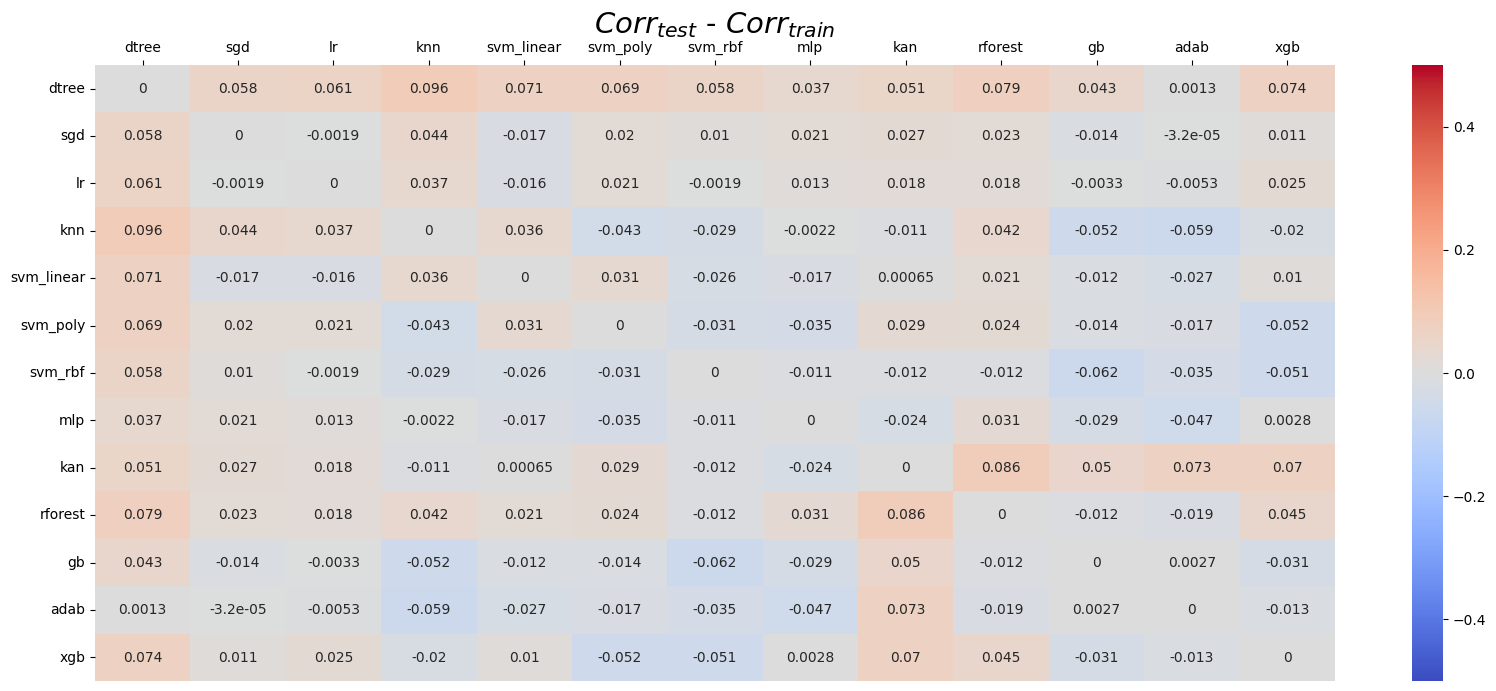

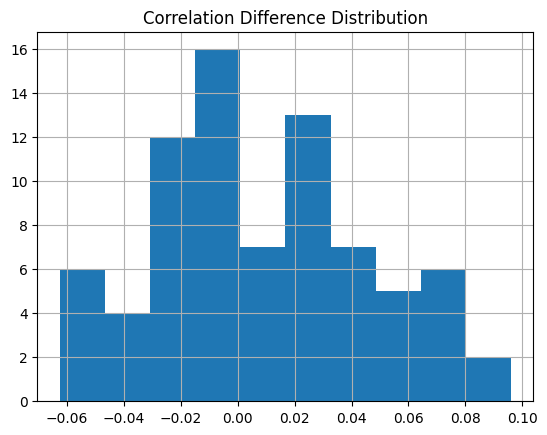

[Saved image "cmd_base.eps"]
[Saved image "cdd_base.eps"]


In [51]:
pred_corrls2 = ya_test.corr('kendall')
diff_corrls = pred_corrls2-pred_corrls
diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações do conjnuto de teste e de treinamento:
MSE: {(diff_corrls_values**2).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()**0.5:.4f}
MAE: {(diff_corrls_values.abs()).mean():.4f}
NMSE: {(diff_corrls_values**2).mean()/corrlArray(pred_corrls)['corr'].var():.4f}
Desvio Padrão: {diff_corrls_values.std():.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{test}$ - $Corr_{train}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Difference Distribution')
hg = diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

## Globais

### Regressor Chain
(RC)

In [52]:
regchain = RegressorChain(RandomForestRegressor(random_state=seed), verbose=True, random_state=seed, cv=5).fit(Xa_train, ya_train)

[Chain] .................. (1 of 13) Processing order 0, total=   0.2s
[Chain] .................. (2 of 13) Processing order 1, total=   0.2s
[Chain] .................. (3 of 13) Processing order 2, total=   0.2s
[Chain] .................. (4 of 13) Processing order 3, total=   0.2s
[Chain] .................. (5 of 13) Processing order 4, total=   0.2s
[Chain] .................. (6 of 13) Processing order 5, total=   0.3s
[Chain] .................. (7 of 13) Processing order 6, total=   0.2s
[Chain] .................. (8 of 13) Processing order 7, total=   0.2s
[Chain] .................. (9 of 13) Processing order 8, total=   0.2s
[Chain] ................. (10 of 13) Processing order 9, total=   0.2s
[Chain] ................ (11 of 13) Processing order 10, total=   0.2s
[Chain] ................ (12 of 13) Processing order 11, total=   0.3s
[Chain] ................ (13 of 13) Processing order 12, total=   0.3s


In [53]:
mse_df = pd.DataFrame(columns=model_names, dtype=float)
#rmse_df = pd.DataFrame(columns=model_names, dtype=float)
nmse_df = pd.DataFrame(columns=model_names, dtype=float)
mae_df = pd.DataFrame(columns=model_names, dtype=float)
nmae_df = pd.DataFrame(columns=model_names, dtype=float)

In [54]:
ya_pred = regchain.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
NMSE: {nmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}
NMAE: {nmae(ya_test, ya_pred)}''')

mse_df.loc['regchain',:] = mse(ya_test, ya_pred, multioutput='raw_values')
nmse_df.loc['regchain',:] = nmse(ya_test, ya_pred, multioutput='raw_values')
mae_df.loc['regchain',:] = mae(ya_test, ya_pred, multioutput='raw_values')
nmae_df.loc['regchain',:] = nmae(ya_test, ya_pred, multioutput='raw_values')
mse_df

MSE: 0.0577
NMSE: 0.9751
MAE: 0.1876
NMAE: 0.9554920004349486


dtree       sgd        lr       knn  svm_linear  svm_poly  \
regchain  0.10278  0.054437  0.049001  0.037969     0.02829  0.015932   

           svm_rbf       mlp       kan   rforest        gb      adab       xgb  
regchain  0.043465  0.068808  0.154218  0.033069  0.059668  0.002471  0.100189

#### Análise das correlações

Melhorar esse cálculo de correlação para fazer melhor uso do 1-(probabilidade da classe correta)

Conjunto de Treinamento:

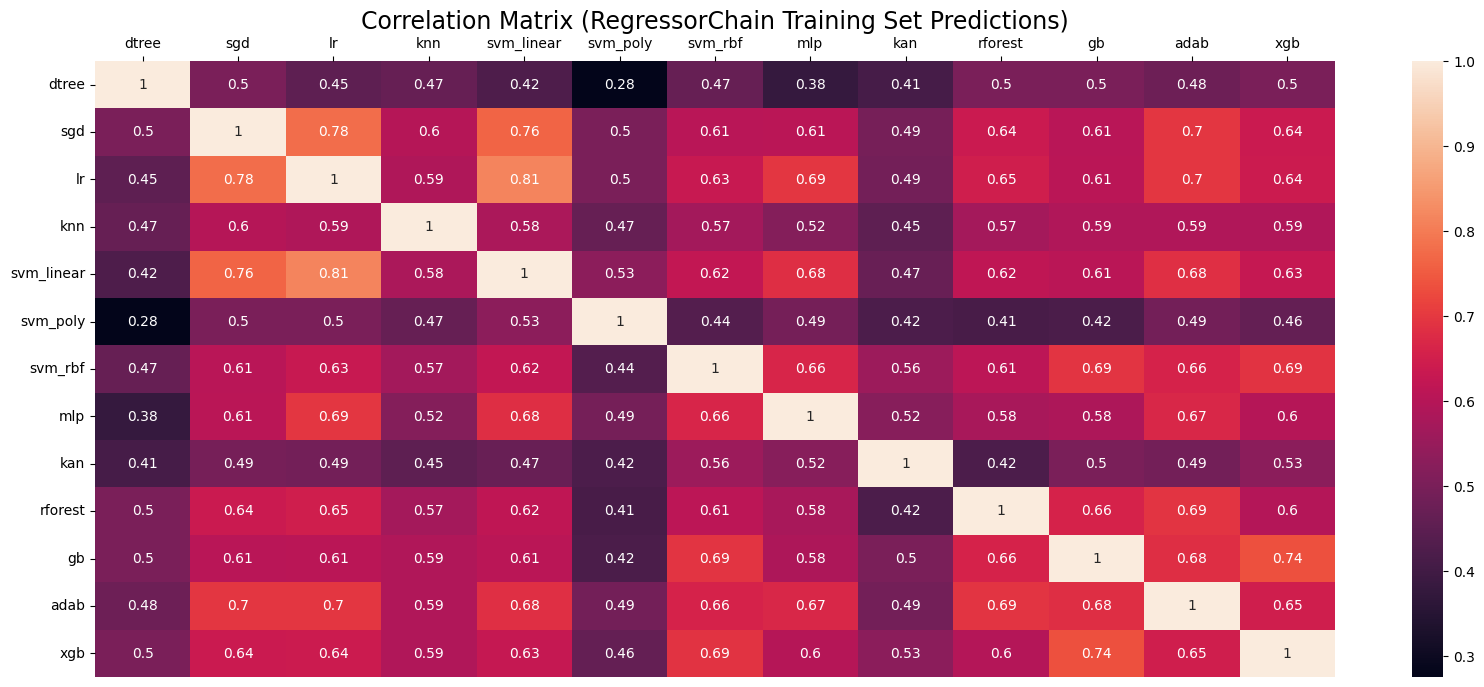

count    78.000000
mean      0.567595
std       0.103690
min       0.275516
25%       0.490069
50%       0.586195
75%       0.639292
max       0.813255
Name: corr, dtype: float64


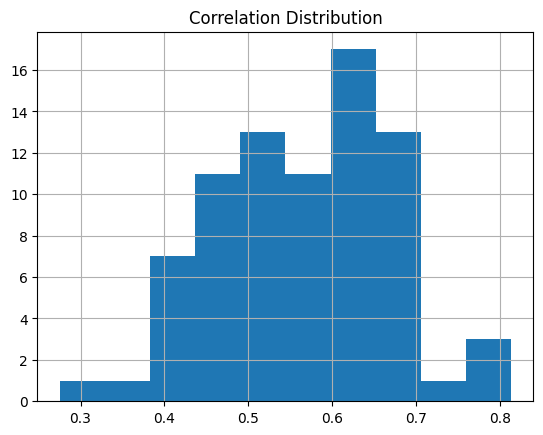

[Saved image "cm_rctrain.eps"]
[Saved image "cd_rctrain.eps"]


In [55]:
regchain_corrls = pd.DataFrame(regchain.predict(Xa_train), 
                               index=Xa_train.index,
                               columns=model_names).corr('kendall') 

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (RegressorChain Training Set Predictions)', fontsize=17)
hm = sns.heatmap(regchain_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

regchain_corrls_values = corrlArray(regchain_corrls)['corr']
print(regchain_corrls_values.describe())

plt.title('Correlation Distribution')
hg = regchain_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [56]:
groups['regchain_assessor_train'] = group_search(regchain_corrls, MIN_SCORE)
groups['regchain_assessor_train']

[['knn'],
 ['xgb', 'gb', 'svm_rbf', 'adab'],
 ['adab', 'svm_rbf', 'mlp'],
 ['gb', 'rforest', 'adab'],
 ['lr', 'adab', 'rforest'],
 ['sgd', 'adab', 'lr', 'svm_linear'],
 ['svm_linear', 'mlp', 'lr', 'adab'],
 ['dtree'],
 ['svm_poly'],
 ['kan']]

Conjunto de Teste:

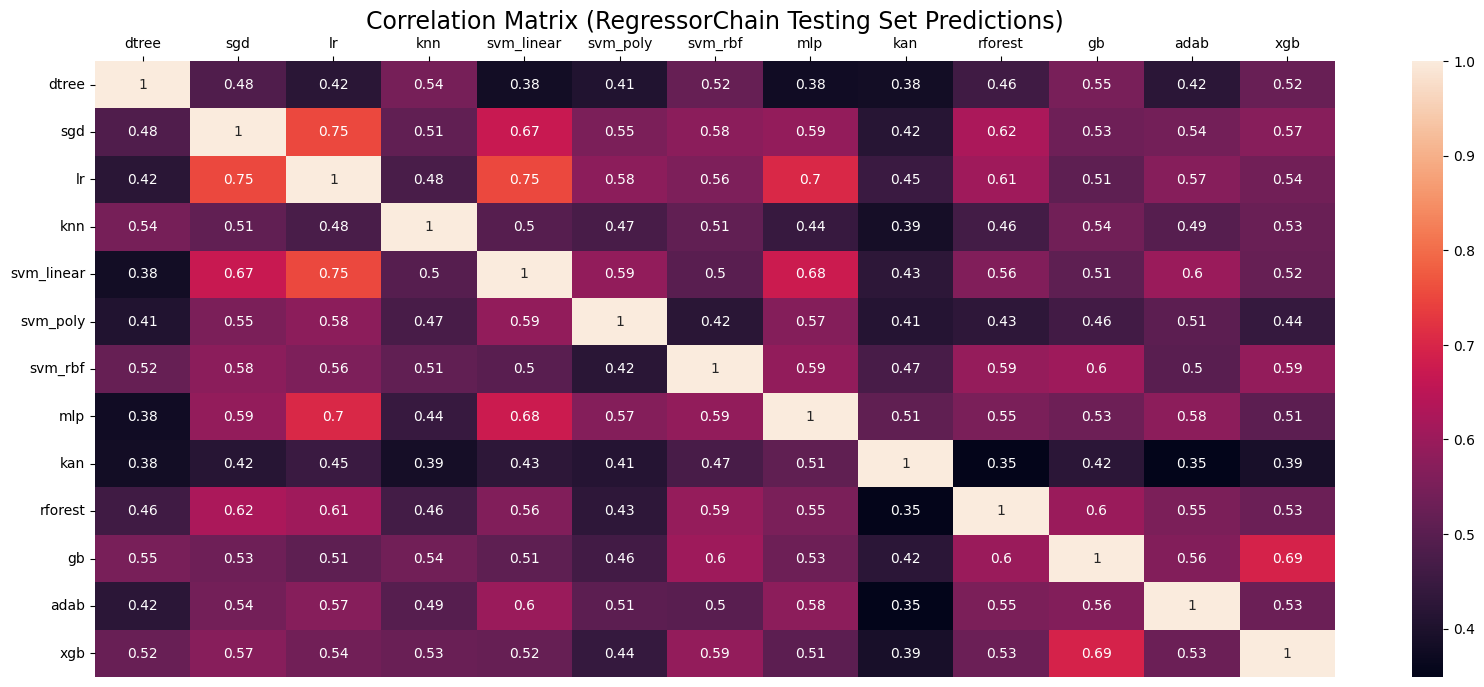

count    78.000000
mean      0.519340
std       0.087323
min       0.348982
25%       0.460613
50%       0.522337
75%       0.571663
max       0.751203
Name: corr, dtype: float64


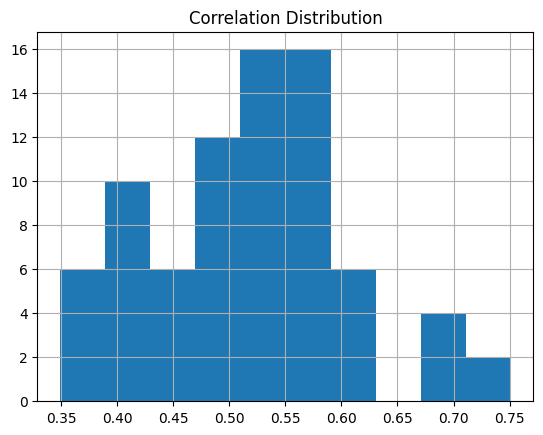

[Saved image "cm_rctest.eps"]
[Saved image "cd_rctest.eps"]


In [57]:
regchain_corrls = pd.DataFrame(regchain.predict(Xa_test), 
                               columns=model_names, 
                               index=Xa_test.index).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (RegressorChain Testing Set Predictions)', fontsize=17)
hm = sns.heatmap(regchain_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

regchain_corrls_values = corrlArray(regchain_corrls)['corr']
print(regchain_corrls_values.describe())

plt.title('Correlation Distribution')
hg = regchain_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [58]:
groups['regchain_assessor_test'] = group_search(regchain_corrls, MIN_SCORE)
groups['regchain_assessor_test']

[['knn'],
 ['xgb', 'gb'],
 ['sgd', 'lr', 'svm_linear'],
 ['lr', 'svm_linear', 'mlp'],
 ['adab'],
 ['dtree'],
 ['svm_poly'],
 ['rforest'],
 ['kan'],
 ['svm_rbf']]

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.4155
MAE: 0.6149
NMSE: 19.0635
NMAE: 5.9158


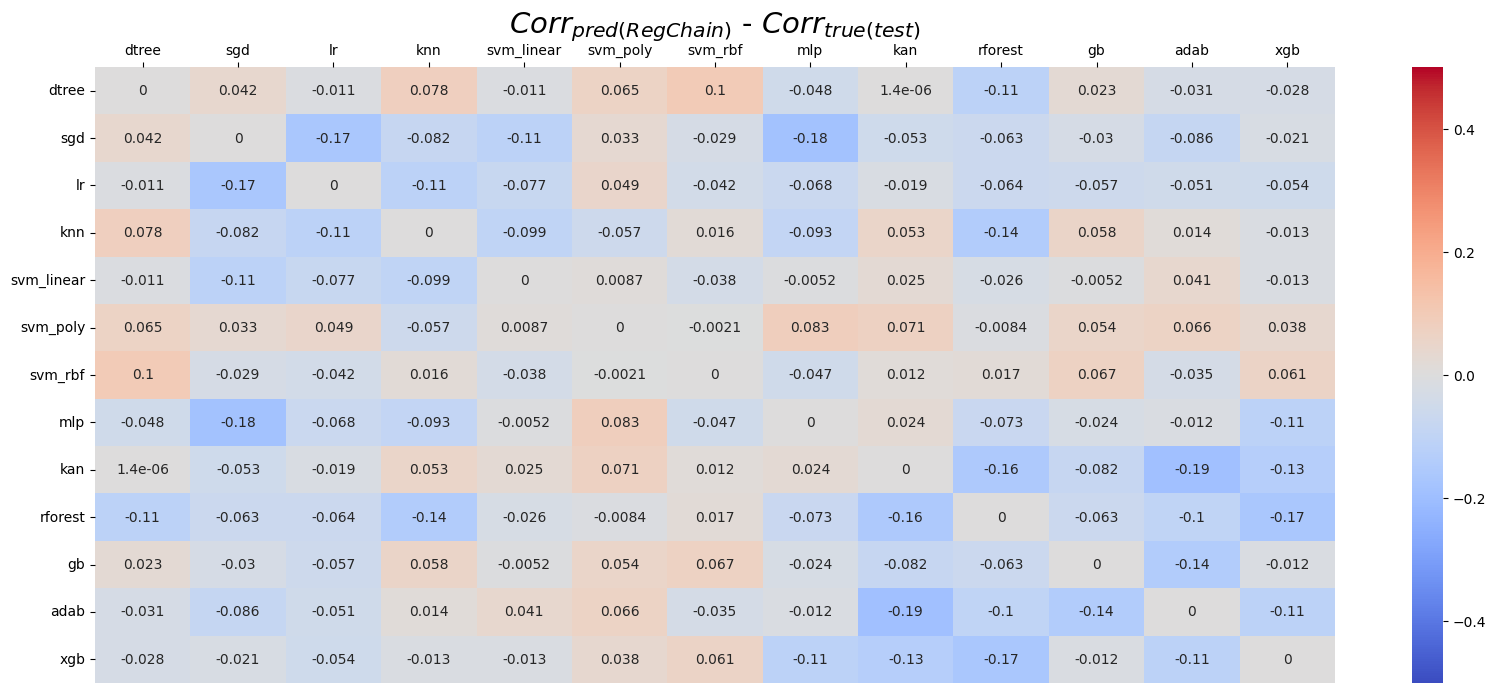

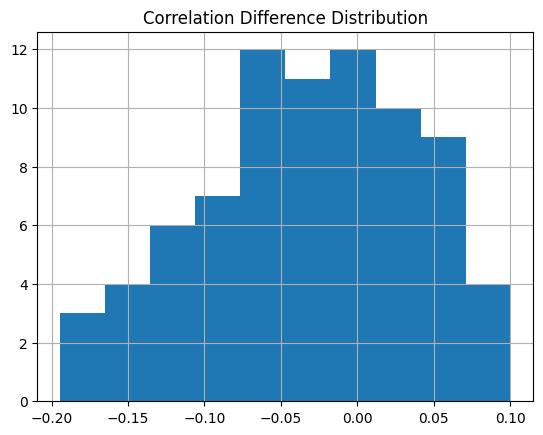

[Saved image "cmd_rc.eps"]
[Saved image "cd_rc.eps"]


In [59]:
pred_corrls2 = ya_test.corr('kendall')
diff_corrls = regchain_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {mse(pred_corrls2, diff_corrls):.4f}
MAE: {mae(pred_corrls2, diff_corrls):.4f}
NMSE: {nmse(pred_corrls2, diff_corrls):.4f}
NMAE: {nmae(pred_corrls2, diff_corrls):.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(RegChain)}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Difference Distribution')
diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

### Multi-Output Random Forest Regressor 

In [60]:
mrf = RandomForestRegressor(random_state=seed, n_jobs=-1).fit(Xa_train, ya_train)

In [61]:
ya_pred = mrf.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
NMSE: {nmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}
NMAE: {nmae(ya_test, ya_pred):.4f}''')

#mse_models(ya_test, ya_pred)
mse_df.loc['multi-rforest',:] = mse(ya_test, ya_pred, multioutput='raw_values')
nmse_df.loc['multi-rforest',:] = nmse(ya_test, ya_pred, multioutput='raw_values')
mae_df.loc['multi-rforest',:] = mae(ya_test, ya_pred, multioutput='raw_values')
nmae_df.loc['multi-rforest',:] = nmae(ya_test, ya_pred, multioutput='raw_values')
mse_df

MSE: 0.0573
NMSE: 0.9737
MAE: 0.1896
NMAE: 0.9681


dtree       sgd        lr       knn  svm_linear  svm_poly  \
regchain       0.102780  0.054437  0.049001  0.037969    0.028290  0.015932   
multi-rforest  0.105173  0.053292  0.048468  0.037025    0.028923  0.016789   

                svm_rbf       mlp       kan   rforest        gb      adab  \
regchain       0.043465  0.068808  0.154218  0.033069  0.059668  0.002471   
multi-rforest  0.042889  0.068405  0.147280  0.033454  0.061516  0.002442   

                    xgb  
regchain       0.100189  
multi-rforest  0.098769

#### Análise das correlações

Conjunto de Treinamento:

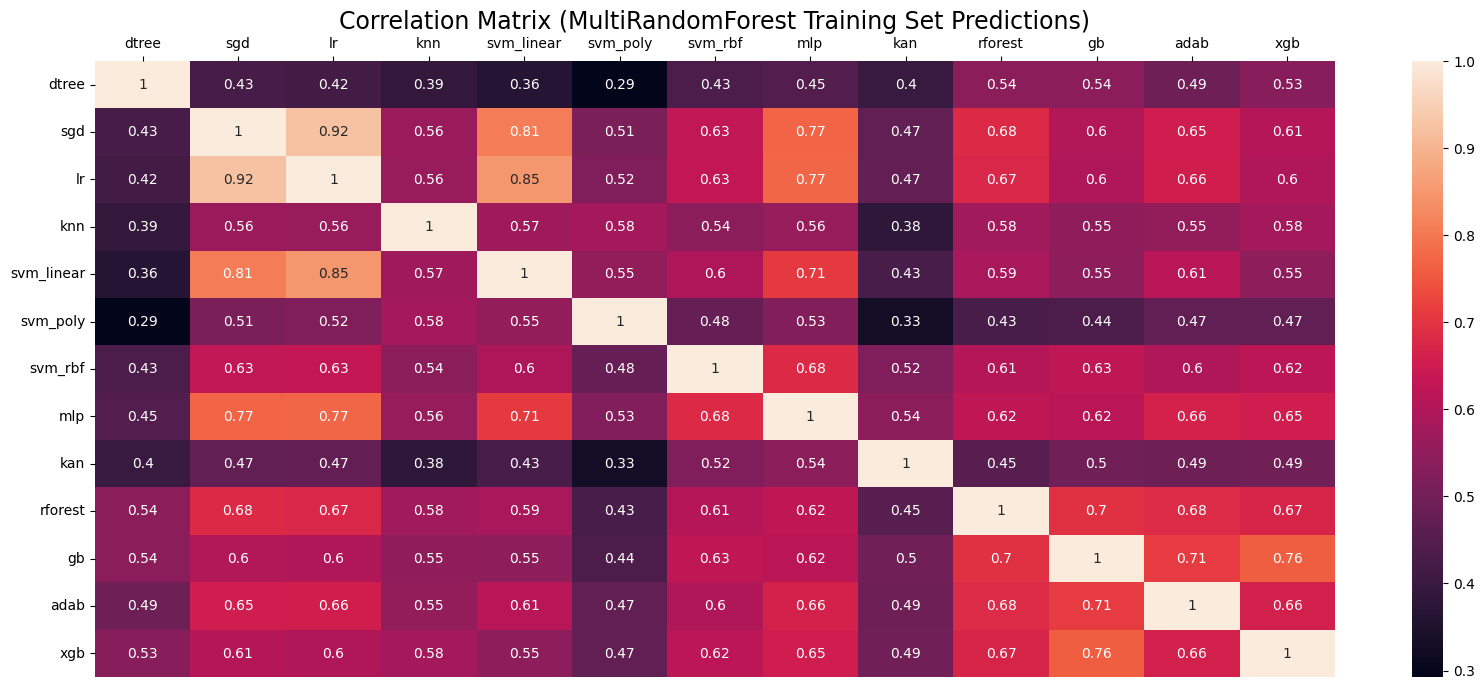

count    78.000000
mean      0.568043
std       0.117776
min       0.292507
25%       0.489243
50%       0.562242
75%       0.630796
max       0.923697
Name: corr, dtype: float64


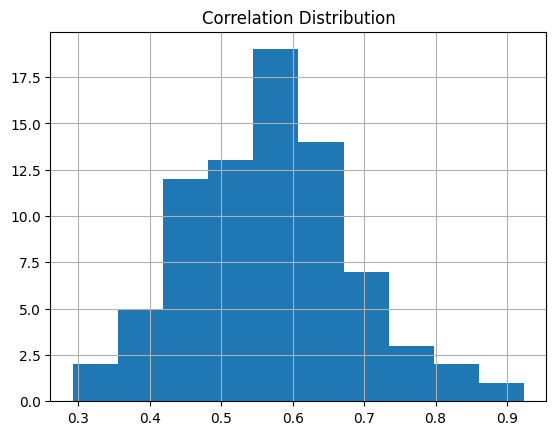

[Saved image "cm_mrftrain.eps"]
[Saved image "cd_mrftrain.eps"]


In [62]:
mrf_corrls = pd.DataFrame(mrf.predict(Xa_train), 
                          columns=model_names, 
                          index=Xa_train.index).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiRandomForest Training Set Predictions)', fontsize=17)
hm = sns.heatmap(mrf_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

mrf_corrls_values = corrlArray(mrf_corrls)['corr']
print(mrf_corrls_values.describe())

plt.title('Correlation Distribution')
hg = mrf_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [63]:
groups['mrf_assessor_train'] = group_search(mrf_corrls, MIN_SCORE)
groups['mrf_assessor_train']

[['xgb', 'mlp', 'adab'],
 ['sgd', 'mlp', 'lr', 'adab'],
 ['sgd', 'mlp', 'lr', 'svm_linear'],
 ['mlp', 'svm_rbf'],
 ['knn'],
 ['xgb', 'gb', 'rforest', 'adab'],
 ['dtree'],
 ['svm_poly'],
 ['sgd', 'lr', 'rforest', 'adab'],
 ['kan']]

Conjunto de Teste:

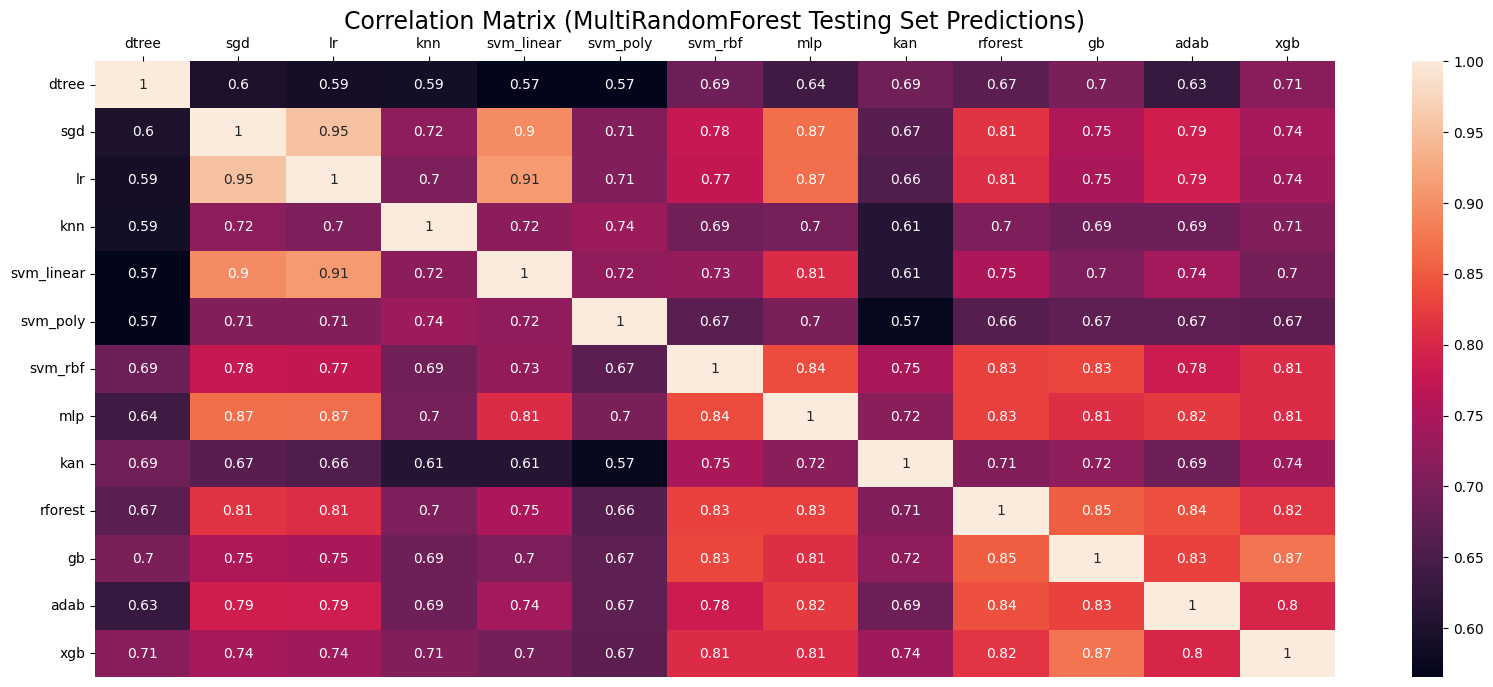

count    78.000000
mean      0.734911
std       0.084646
min       0.565636
25%       0.688263
50%       0.721544
75%       0.805498
max       0.954005
Name: corr, dtype: float64


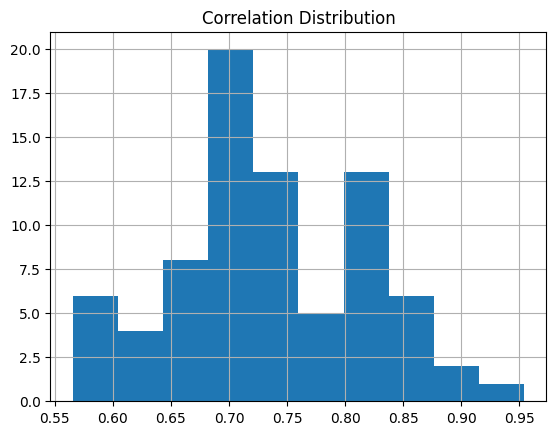

[Saved image "cm_mrftest.eps"]
[Saved image "cd_mrftest.eps"]


In [64]:
mrf_corrls = pd.DataFrame(ya_pred, 
                          columns=model_names, 
                          index=Xa_test.index, dtype=float).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiRandomForest Testing Set Predictions)', fontsize=17)
hm = sns.heatmap(mrf_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

mrf_corrls_values = corrlArray(mrf_corrls)['corr']
print(mrf_corrls_values.describe())

plt.title('Correlation Distribution')
hg = mrf_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [65]:
groups['mrf_assessor_test'] = group_search(mrf_corrls, MIN_SCORE)
groups['mrf_assessor_test']

[['xgb', 'gb', 'dtree', 'rforest', 'kan', 'svm_rbf'],
 ['mlp', 'xgb', 'lr', 'gb', 'adab', 'sgd', 'rforest', 'kan', 'svm_rbf'],
 ['mlp',
  'knn',
  'xgb',
  'lr',
  'gb',
  'adab',
  'sgd',
  'svm_linear',
  'svm_poly',
  'rforest',
  'svm_rbf']]

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.2236
MAE: 0.4159
NMSE: 10.1682
NMAE: 3.9716


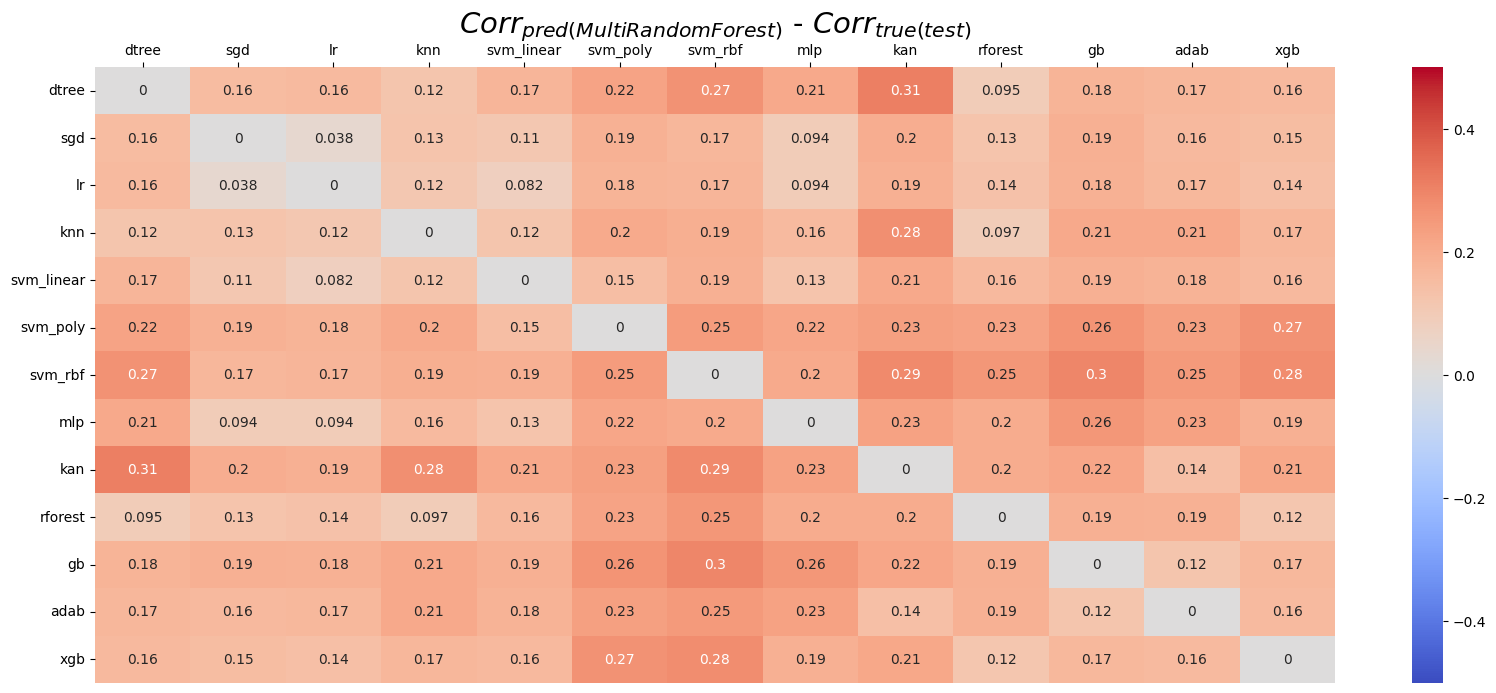

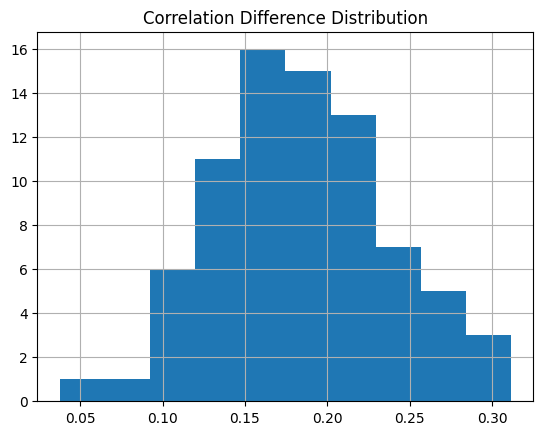

[Saved image "cmd_mrf.eps"]
[Saved image "cdd_mrf.eps"]


In [66]:
pred_corrls2 = ya_test.corr('kendall')
diff_corrls = mrf_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {mse(pred_corrls2, diff_corrls):.4f}
MAE: {mae(pred_corrls2, diff_corrls):.4f}
NMSE: {nmse(pred_corrls2, diff_corrls):.4f}
NMAE: {nmae(pred_corrls2, diff_corrls):.4f}''')


plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(MultiRandomForest)}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Difference Distribution')
hg = diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

### Multi-Output SVR

In [67]:
from MSVR import MSVR

msvr = MSVR()
msvr.fit(np.asarray(Xb_test_norm), np.asarray(ya_train))

In [68]:
ya_pred = msvr.predict(Xa_test_norm)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}
NMSE: {nmse(ya_test, ya_pred):.4f}
NMAE: {nmae(ya_test, ya_pred):.4f}''')

#mse_models(ya_test, ya_pred)
mse_df.loc['multi-svr',:] = mse(ya_test, ya_pred, multioutput='raw_values')
nmse_df.loc['multi-svr',:] = nmse(ya_test, ya_pred, multioutput='raw_values')
mae_df.loc['multi-svr',:] = mae(ya_test, ya_pred, multioutput='raw_values')
nmae_df.loc['multi-svr',:] = nmae(ya_test, ya_pred, multioutput='raw_values')

MSE: 0.0630
MAE: 0.1888
NMSE: 1.3321
NMAE: 1.0259


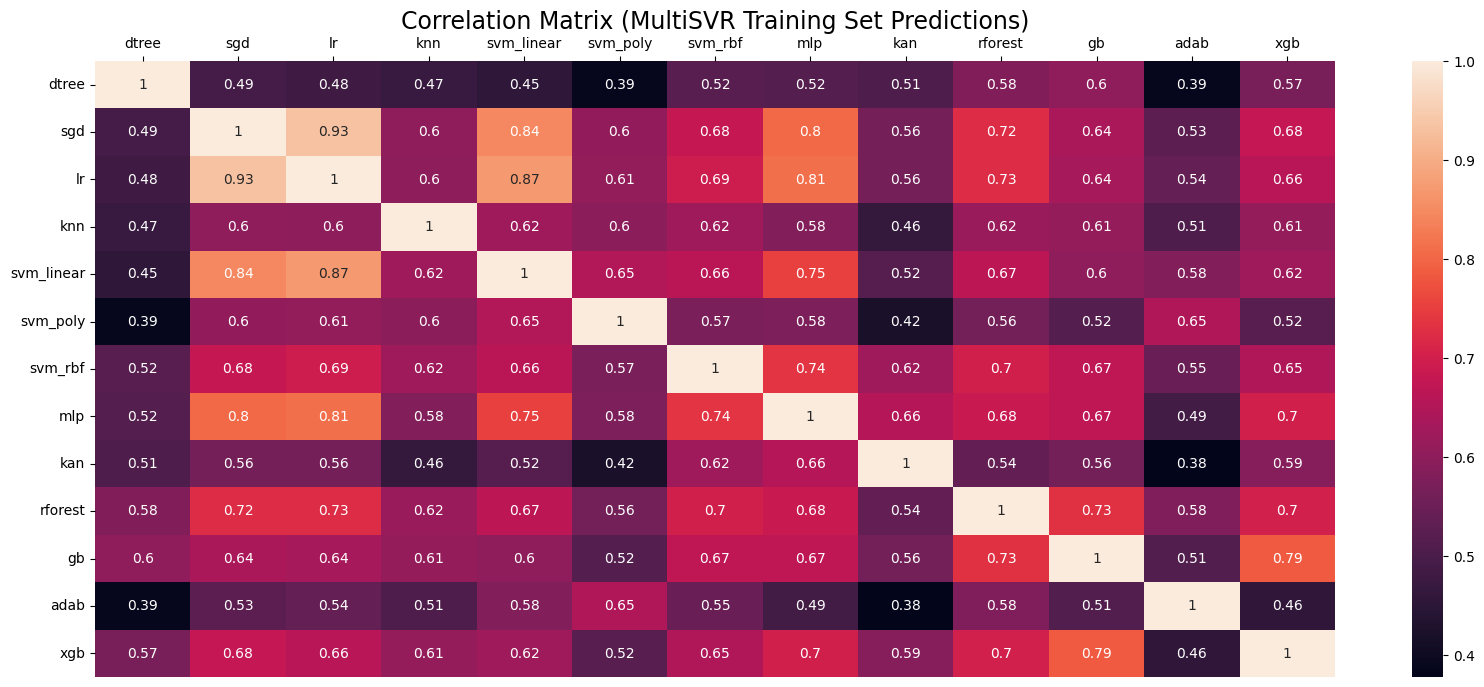

count    78.000000
mean      0.606583
std       0.109435
min       0.377699
25%       0.528673
50%       0.602871
75%       0.669440
max       0.932665
Name: corr, dtype: float64


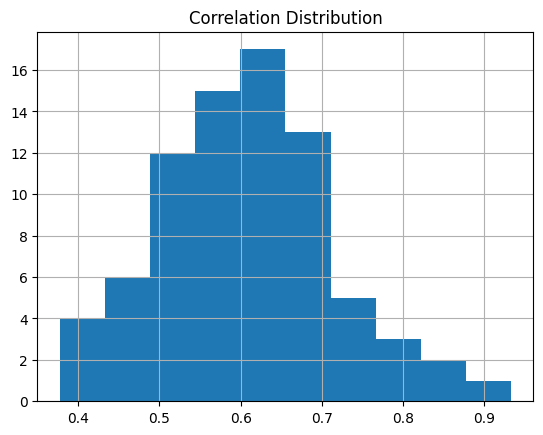

[Saved image "cm_msvrtrain.eps"]
[Saved image "cd_msvrtrain.eps"]


In [69]:
msvr_corrls = pd.DataFrame(msvr.predict(Xb_test_norm),
                          columns=model_names,
                          index=Xa_train.index).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiSVR Training Set Predictions)', fontsize=17)
hm = sns.heatmap(msvr_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

msvr_corrls_values = corrlArray(msvr_corrls)['corr']
print(msvr_corrls_values.describe())

plt.title('Correlation Distribution')
hg = msvr_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [70]:
groups['msvr_assessor_train'] = group_search(msvr_corrls, MIN_SCORE)
groups['msvr_assessor_train']

[['kan', 'mlp'],
 ['mlp', 'xgb', 'lr', 'sgd', 'rforest', 'svm_rbf'],
 ['mlp', 'xgb', 'gb', 'rforest', 'svm_rbf'],
 ['mlp', 'lr', 'sgd', 'rforest', 'svm_linear', 'svm_rbf'],
 ['knn'],
 ['adab', 'svm_poly'],
 ['dtree'],
 ['svm_poly', 'svm_linear']]

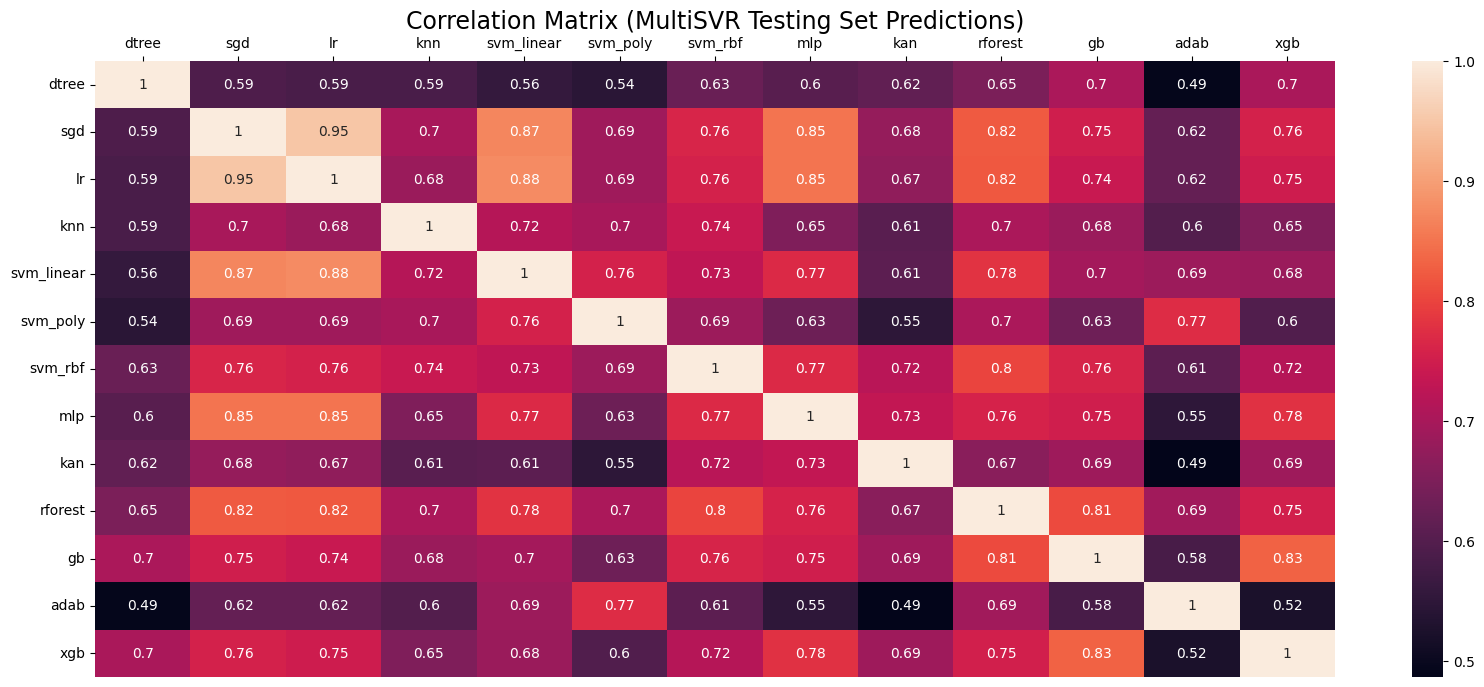

count    78.000000
mean      0.694517
std       0.092694
min       0.486757
25%       0.621332
50%       0.694475
75%       0.756542
max       0.949775
Name: corr, dtype: float64


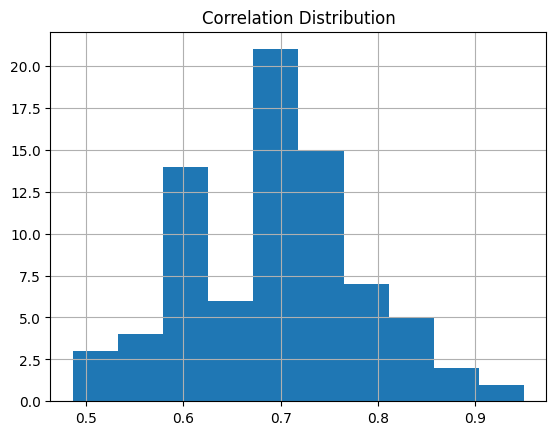

[Saved image "cm_msvrtest.eps"]
[Saved image "cd_msvrtest.eps"]


In [71]:
msvr_corrls = pd.DataFrame(ya_pred,
                          columns=model_names,
                          index=Xa_test.index, dtype=float).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiSVR Testing Set Predictions)', fontsize=17)
hm = sns.heatmap(msvr_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

msvr_corrls_values = corrlArray(msvr_corrls)['corr']
print(msvr_corrls_values.describe())

plt.title('Correlation Distribution')
hg = msvr_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.2586
MAE: 0.4532
NMSE: 11.8810
NMAE: 4.3450


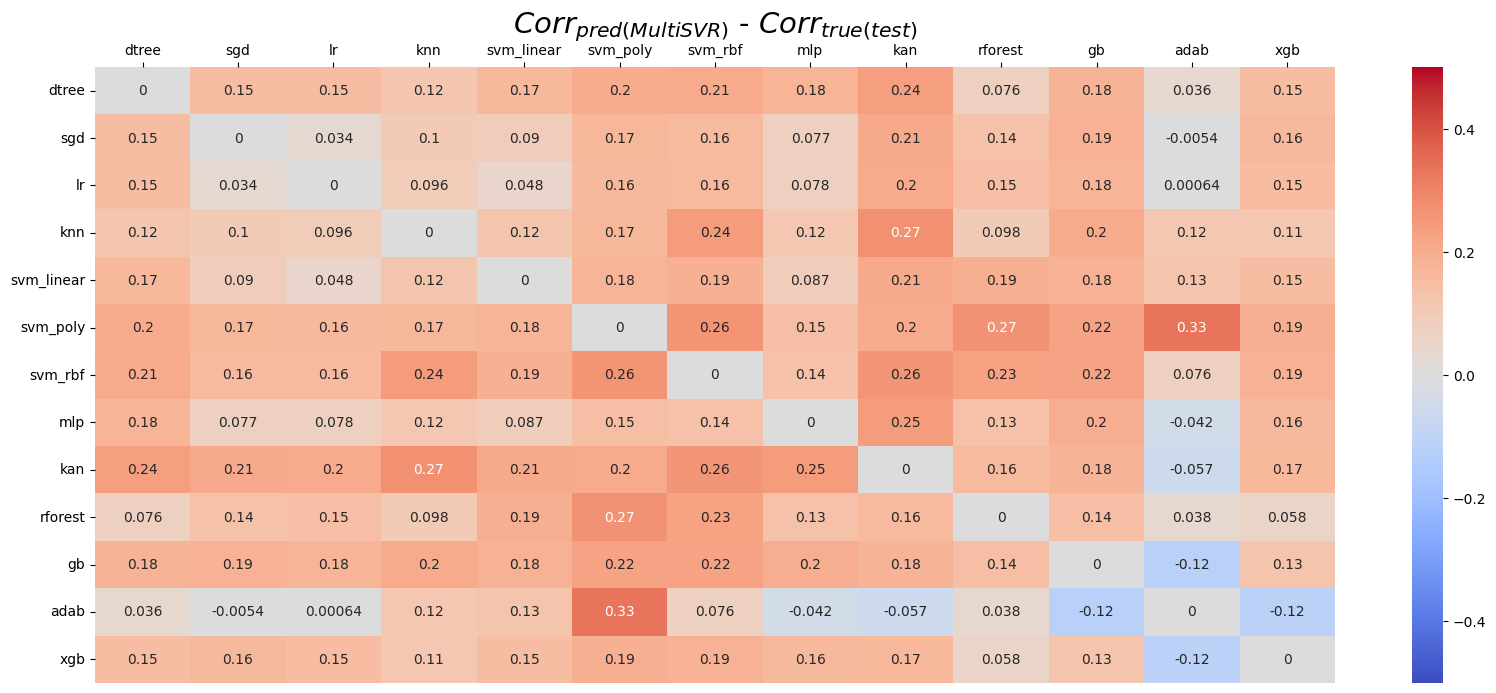

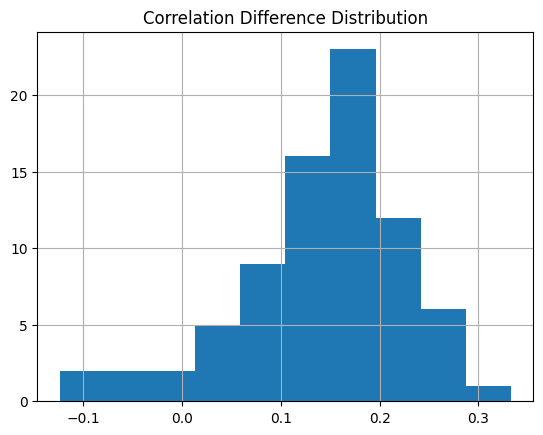

[Saved image "cmd_msvr.eps"]
[Saved image "cdd_msvr.eps"]


In [72]:
pred_corrls2 = ya_test.corr('kendall')
diff_corrls = msvr_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {mse(pred_corrls2, diff_corrls):.4f}
MAE: {mae(pred_corrls2, diff_corrls):.4f}
NMSE: {nmse(pred_corrls2, diff_corrls):.4f}
NMAE: {nmae(pred_corrls2, diff_corrls):.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(MultiSVR)}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Difference Distribution')
hg = diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [73]:
groups['msvr_assessor_test'] = group_search(msvr_corrls, MIN_SCORE)
groups['msvr_assessor_test']

[['dtree', 'xgb', 'gb', 'rforest'],
 ['mlp', 'xgb', 'lr', 'gb', 'sgd', 'rforest', 'kan', 'svm_rbf'],
 ['mlp', 'knn', 'xgb', 'lr', 'gb', 'sgd', 'svm_linear', 'rforest', 'svm_rbf'],
 ['rforest', 'adab', 'svm_poly', 'svm_linear'],
 ['knn', 'lr', 'sgd', 'svm_linear', 'svm_poly', 'rforest', 'svm_rbf']]

### Multi-Output Regressor 
(ST)

In [74]:
mor = MultiOutputRegressor(RandomForestRegressor(random_state=seed), n_jobs=-1).fit(Xa_train, ya_train)

In [75]:
ya_pred = mor.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
RMSE: {rmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}
NMAE: {nmae(ya_test, ya_pred):.4f}''')

#mse_models(ya_test, ya_pred)
mse_df.loc['multi-output',:] = mse(ya_test, ya_pred, multioutput='raw_values')
nmse_df.loc['multi-output',:] = nmse(ya_test, ya_pred, multioutput='raw_values')
mae_df.loc['multi-output',:] = mae(ya_test, ya_pred, multioutput='raw_values')
nmae_df.loc['multi-output',:] = nmae(ya_test, ya_pred, multioutput='raw_values')
mse_df

MSE: 0.0572
RMSE: 0.2236
MAE: 0.1873
NMAE: 0.9538


dtree       sgd        lr       knn  svm_linear  svm_poly  \
regchain       0.102780  0.054437  0.049001  0.037969    0.028290  0.015932   
multi-rforest  0.105173  0.053292  0.048468  0.037025    0.028923  0.016789   
multi-svr      0.114698  0.055706  0.052341  0.044509    0.035550  0.019780   
multi-output   0.102780  0.051025  0.048075  0.036667    0.028684  0.016634   

                svm_rbf       mlp       kan   rforest        gb      adab  \
regchain       0.043465  0.068808  0.154218  0.033069  0.059668  0.002471   
multi-rforest  0.042889  0.068405  0.147280  0.033454  0.061516  0.002442   
multi-svr      0.051493  0.079535  0.151139  0.036448  0.063642  0.011058   
multi-output   0.044201  0.068327  0.152492  0.031263  0.060466  0.002374   

                    xgb  
regchain       0.100189  
multi-rforest  0.098769  
multi-svr      0.102871  
multi-output   0.100638

#### Análise das correlações

Conjunto de Treinamento:

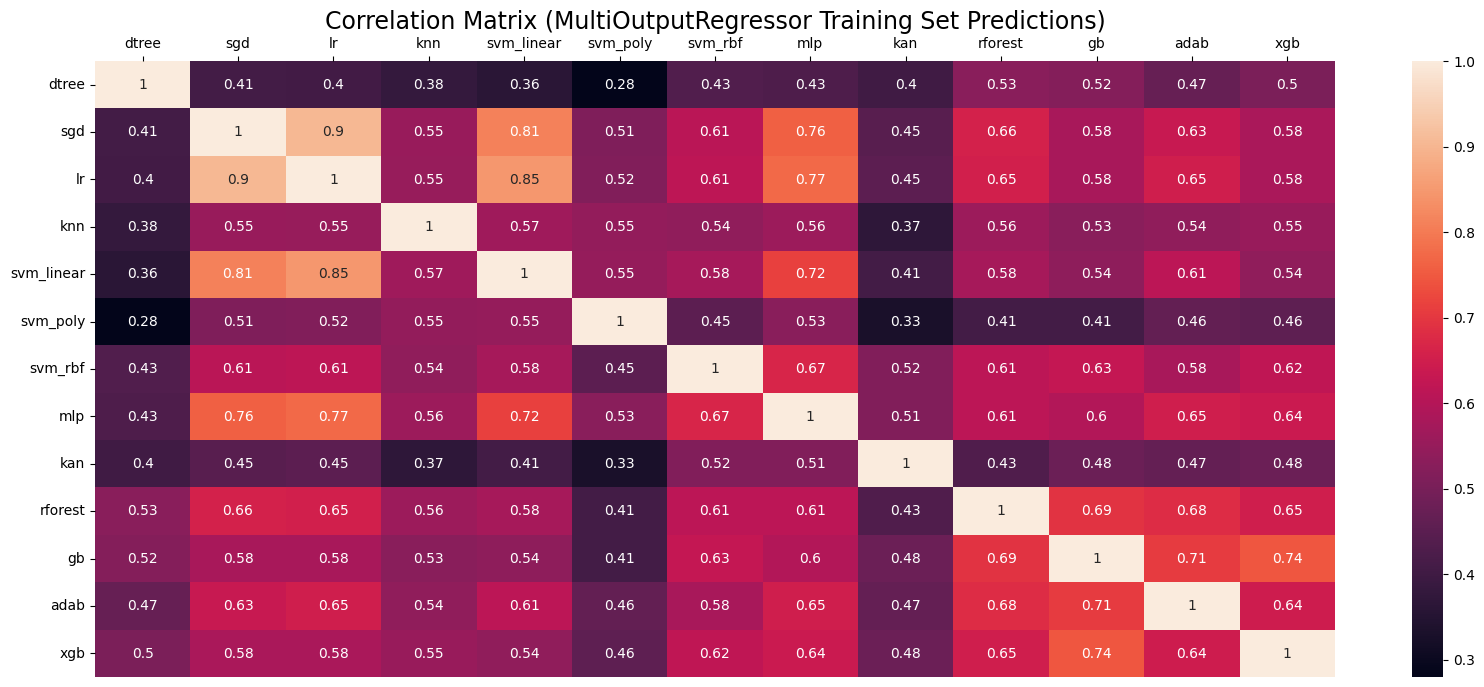

count    78.000000
mean      0.555092
std       0.119151
min       0.279685
25%       0.466391
50%       0.552999
75%       0.625506
max       0.904267
Name: corr, dtype: float64


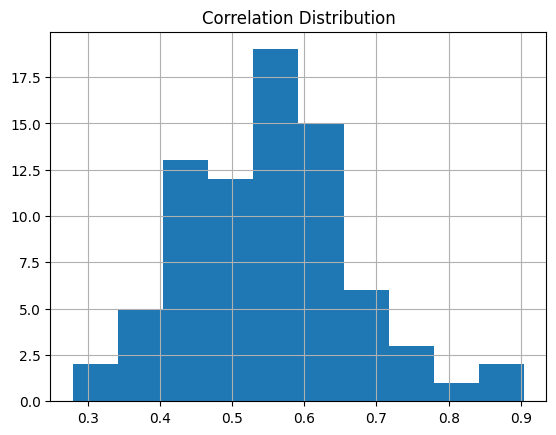

[Saved image "cm_mortrain.eps"]
[Saved image "cd_mortrain.eps"]


In [76]:
mor_corrls = pd.DataFrame(mor.predict(Xa_train), 
                          columns=model_names, 
                          index=Xa_train.index).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiOutputRegressor Training Set Predictions)', fontsize=17)
hm = sns.heatmap(mor_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

mor_corrls_values = corrlArray(mor_corrls)['corr']
print(mor_corrls_values.describe())

plt.title('Correlation Distribution')
hg = mor_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [77]:
groups['mor_assessor_train'] = group_search(mor_corrls, MIN_SCORE)
groups['mor_assessor_train']

[['sgd', 'mlp', 'lr', 'svm_linear'],
 ['mlp', 'lr', 'adab'],
 ['mlp', 'svm_rbf'],
 ['knn'],
 ['xgb', 'gb', 'rforest'],
 ['gb', 'rforest', 'adab'],
 ['dtree'],
 ['svm_poly'],
 ['sgd', 'lr', 'rforest'],
 ['lr', 'rforest', 'adab'],
 ['kan']]

Conjunto de Teste:

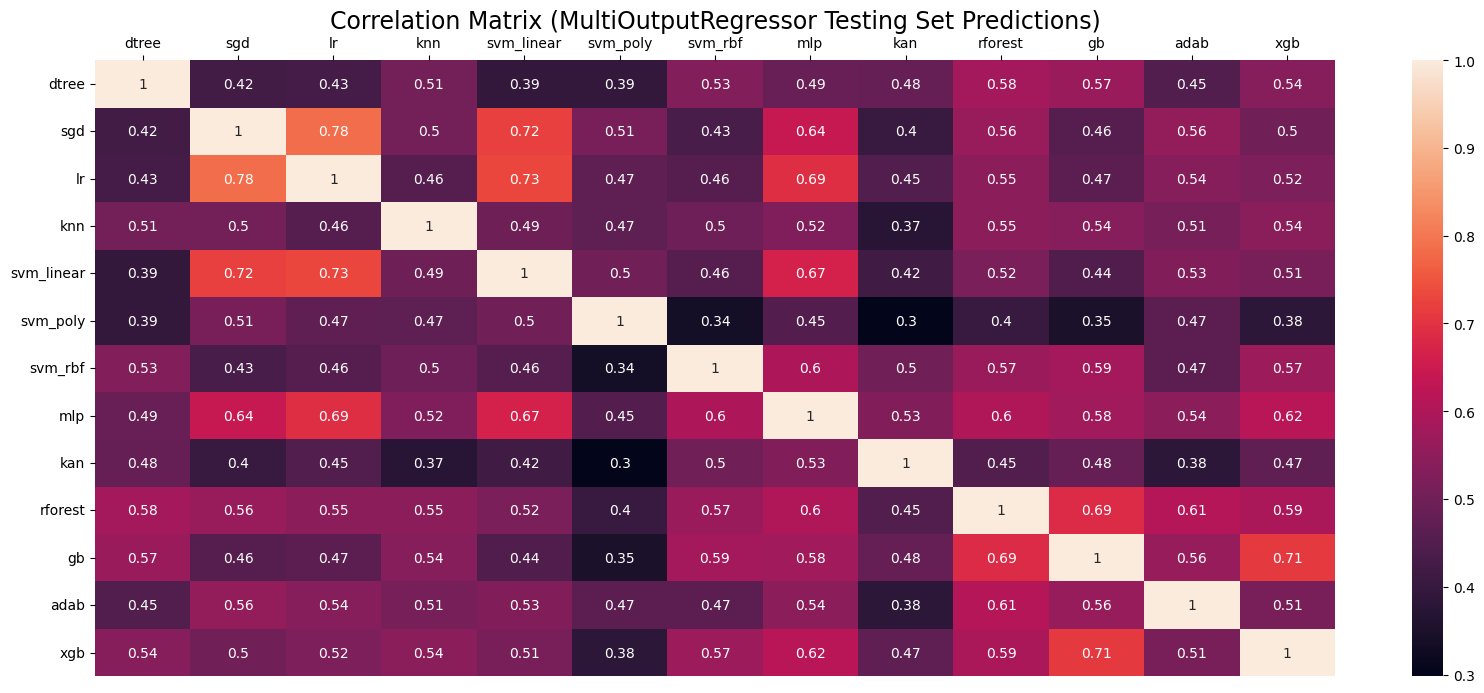

count    78.000000
mean      0.513012
std       0.093689
min       0.298017
25%       0.456754
50%       0.507798
75%       0.563918
max       0.784298
Name: corr, dtype: float64


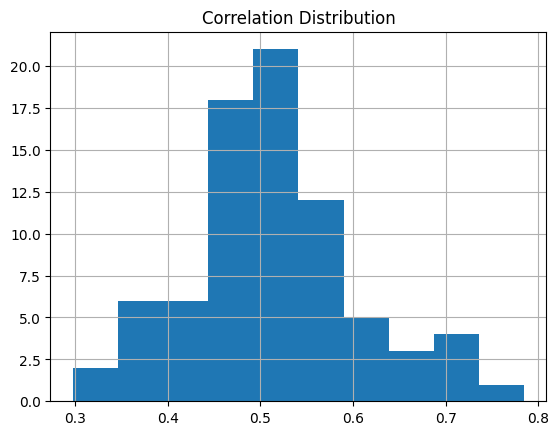

[Saved image "cm_mortest.eps"]
[Saved image "cd_mortest.eps"]


In [78]:
mor_corrls = pd.DataFrame(ya_pred, 
                          columns=model_names, 
                          index=Xa_test.index, dtype=float).corr('kendall')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiOutputRegressor Testing Set Predictions)', fontsize=17)
hm = sns.heatmap(mor_corrls, annot=True)
hm.xaxis.tick_top()
plt.show(hm)

mor_corrls_values = corrlArray(mor_corrls)['corr']
print(mor_corrls_values.describe())

plt.title('Correlation Distribution')
hg = mor_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

In [79]:
groups['mor_assessor_test'] = group_search(mor_corrls, MIN_SCORE)
groups['mor_assessor_test']

[['knn'],
 ['xgb', 'gb'],
 ['gb', 'rforest'],
 ['sgd', 'lr', 'svm_linear'],
 ['lr', 'svm_linear', 'mlp'],
 ['adab'],
 ['dtree'],
 ['svm_poly'],
 ['kan'],
 ['svm_rbf']]

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.4197
MAE: 0.6207
NMSE: 19.1547
NMAE: 5.9566


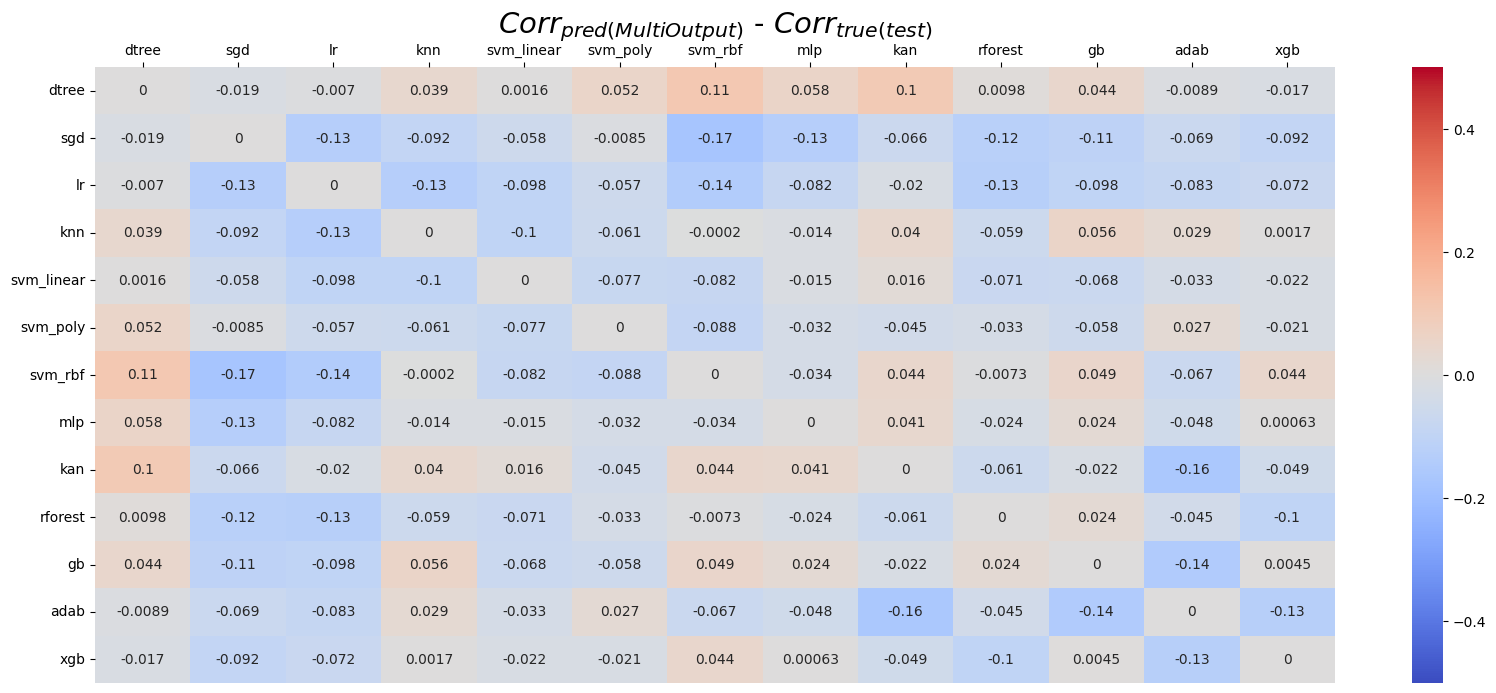

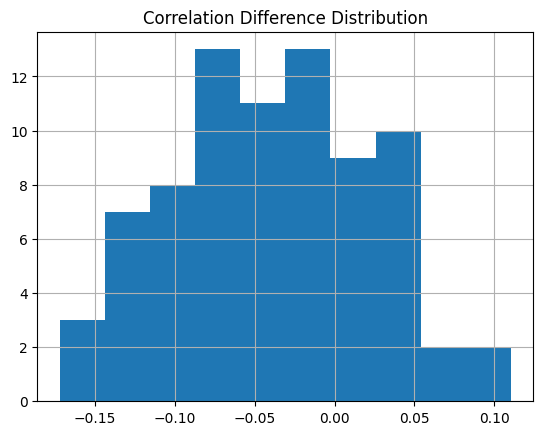

[Saved image "cmd_mo.eps"]
[Saved image "cdd_mo.eps"]


In [80]:
pred_corrls2 = ya_test.corr('kendall')
diff_corrls = mor_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {mse(pred_corrls2, diff_corrls):.4f}
MAE: {mae(pred_corrls2, diff_corrls):.4f}
NMSE: {nmse(pred_corrls2, diff_corrls):.4f}
NMAE: {nmae(pred_corrls2, diff_corrls):.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(MultiOutput)}$ - $Corr_{true(test)}$', fontsize=21)
hm = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Difference Distribution')
hg = diff_corrls_values.hist()
plt.show(hg)

save2figs(hm, hg, DIR)

## Grupais

In [81]:
keys = list(groups.keys())
for i in range(len(keys)):
    for j in range(i+1, len(keys)):
        print(f'{keys[i]}({len(groups[keys[i]])}) & {keys[j]}({len(groups[keys[j]])}):')
        count = 0
        for g in groups[keys[i]]:
            if(g in groups[keys[j]]):
                print(g)
                count += 1
        print(f'Número de grupos em comum: {count}\n\n')

true_assessor_train(8) & true_assessor_test(9):
['sgd', 'mlp', 'lr', 'svm_linear']
['knn']
['dtree']
['svm_poly']
['kan']
['sgd', 'lr', 'rforest']
['svm_rbf']
Número de grupos em comum: 7


true_assessor_train(8) & regchain_assessor_train(10):
['knn']
['dtree']
['svm_poly']
['kan']
Número de grupos em comum: 4


true_assessor_train(8) & regchain_assessor_test(10):
['knn']
['dtree']
['svm_poly']
['kan']
['svm_rbf']
Número de grupos em comum: 5


true_assessor_train(8) & mrf_assessor_train(10):
['sgd', 'mlp', 'lr', 'svm_linear']
['knn']
['dtree']
['svm_poly']
['kan']
['xgb', 'gb', 'rforest', 'adab']
Número de grupos em comum: 6


true_assessor_train(8) & mrf_assessor_test(3):
Número de grupos em comum: 0


true_assessor_train(8) & msvr_assessor_train(8):
['knn']
['dtree']
Número de grupos em comum: 2


true_assessor_train(8) & msvr_assessor_test(5):
Número de grupos em comum: 0


true_assessor_train(8) & mor_assessor_train(11):
['sgd', 'mlp', 'lr', 'svm_linear']
['knn']
['dtree']
['svm_p

In [82]:
for g in groups['true_assessor_train']:
    if(len(g)!=1):
        teste = []
        for i, m in enumerate(g):
            for n in g[i+1:]:
                teste.append(pred_corrls.loc[m,n])
        print(g)
        print(f'total: {np.mean(teste)}\n')

['sgd', 'mlp', 'lr', 'svm_linear']
total: 0.795332677810554

['xgb', 'gb', 'rforest', 'adab']
total: 0.6817833292514416

['sgd', 'lr', 'rforest']
total: 0.745132743362832



### Regressor Chain

In [83]:
regchain4groups = []

for g in groups['true_assessor_train']:
    model = RegressorChain(RandomForestRegressor(random_state=seed), verbose=False, random_state=seed, cv=5).fit(Xa_train, ya_train[g])
    regchain4groups.append(model)

In [84]:
%%capture
y_pred = pd.DataFrame(columns=model_names)

for i, g in enumerate(groups['true_assessor_train']):
    temp = pd.DataFrame(columns=model_names)
    temp[g] = regchain4groups[i].predict(Xa_test)
    y_pred = pd.concat([y_pred, temp])

y_pred = y_pred.groupby(y_pred.index).aggregate('mean')

MSE: 0.0573
MAE: 0.1866
NMSE: 0.9713
NMAE: 0.9537


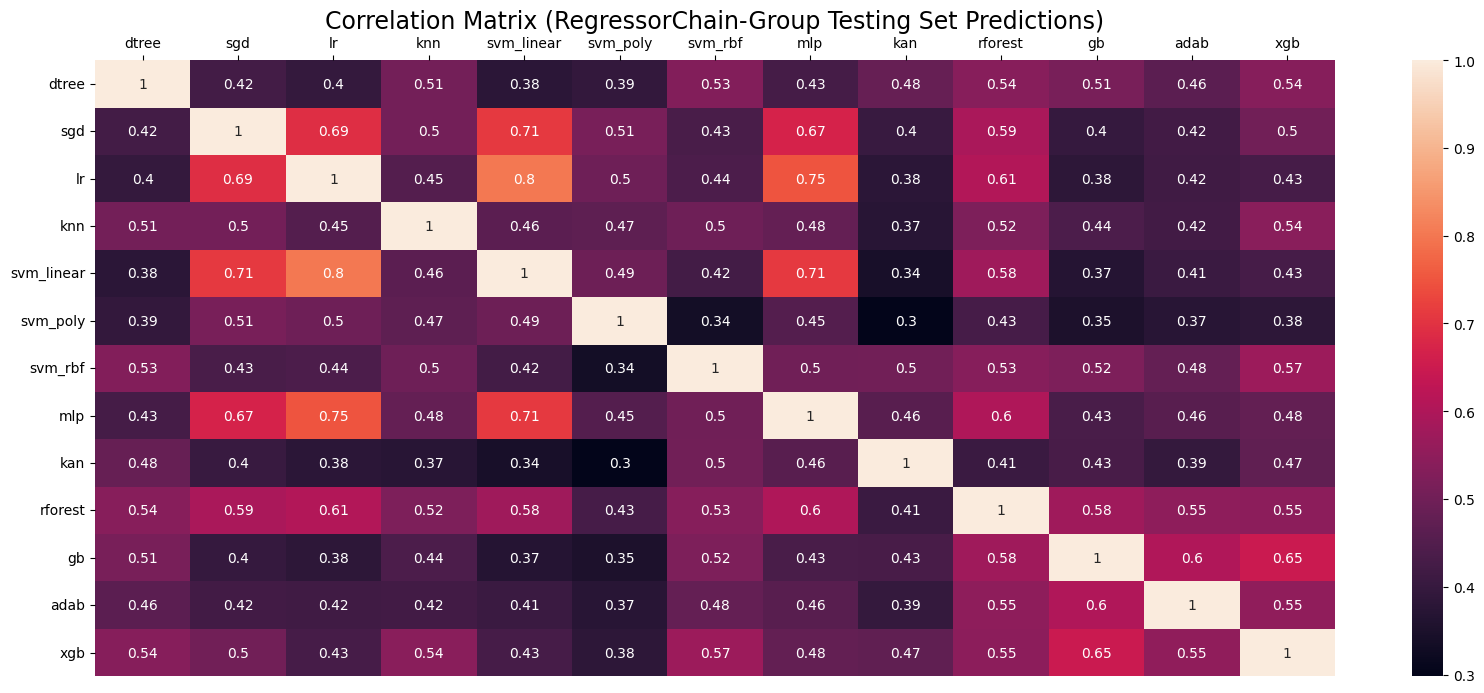

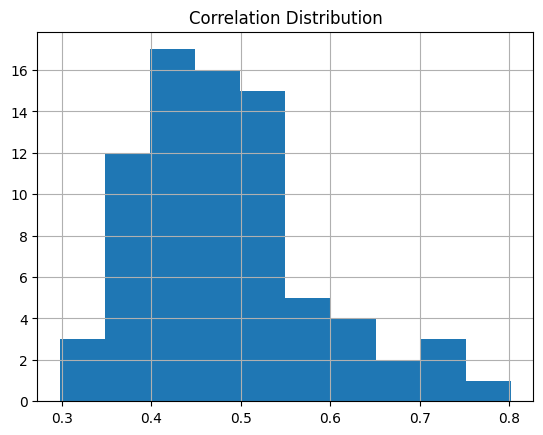

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.4510
MAE: 0.6461
NMSE: 20.6191
NMAE: 6.2015


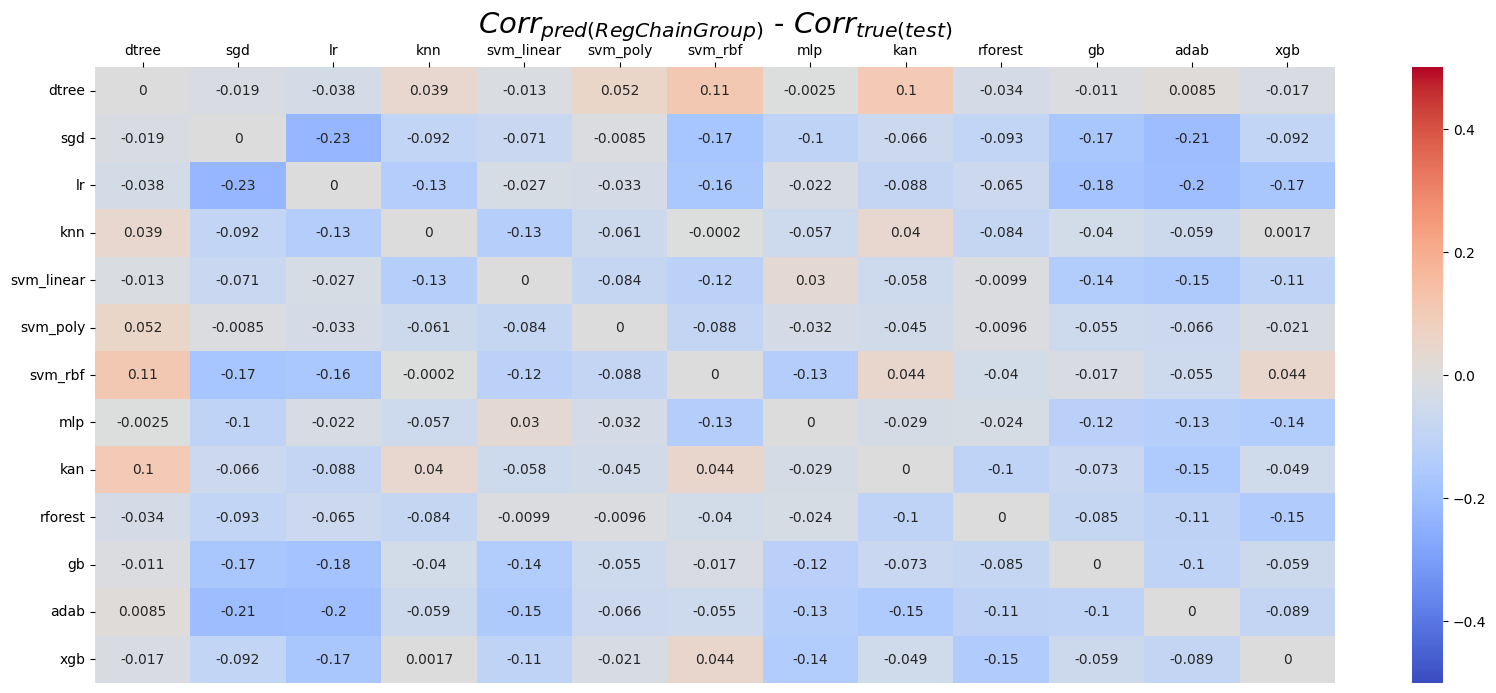

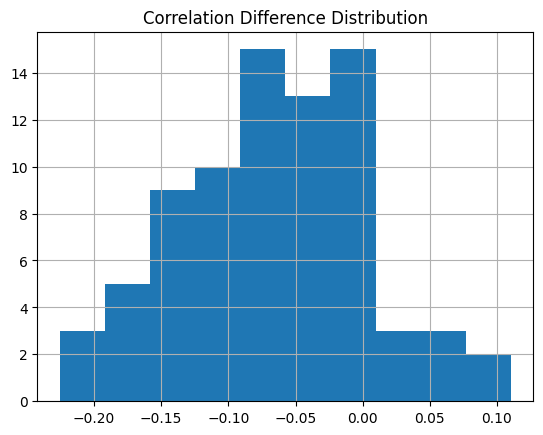

[Saved image "cm_rcgtest.eps"]
[Saved image "cd_rcgtest.eps"]
[Saved image "cmd_rcg.eps"]
[Saved image "cdd_rcg.eps"]


In [85]:
regchainGroups_corrls = y_pred.corr('kendall')
pred_corrls2 = ya_test.corr('kendall')

print(f'''MSE: {mse(ya_test, y_pred):.4f}
MAE: {mae(ya_test, y_pred):.4f}
NMSE: {nmse(ya_test, y_pred):.4f}
NMAE: {nmae(ya_test, y_pred):.4f}''')

mse_df.loc['regchain(group)',:] = mse(ya_test, y_pred, multioutput='raw_values')
mae_df.loc['regchain(group)',:] = mae(ya_test, y_pred, multioutput='raw_values')
nmse_df.loc['regchain(group)',:] = nmse(ya_test, y_pred, multioutput='raw_values')
nmae_df.loc['regchain(group)',:] = nmae(ya_test, y_pred, multioutput='raw_values')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (RegressorChain-Group Testing Set Predictions)', fontsize=17)
hm1 = sns.heatmap(regchainGroups_corrls, annot=True)
hm1.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Distribution')
hg1 = corrlArray(regchainGroups_corrls)['corr'].hist()
plt.show(hg1)

diff_corrls = regchainGroups_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {mse(pred_corrls2, diff_corrls):.4f}
MAE: {mae(pred_corrls2, diff_corrls):.4f}
NMSE: {nmse(pred_corrls2, diff_corrls):.4f}
NMAE: {nmae(pred_corrls2, diff_corrls):.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(RegChainGroup)}$ - $Corr_{true(test)}$', fontsize=21)
hm2 = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm2.xaxis.tick_top()
plt.show(hm2)

plt.title('Correlation Difference Distribution')
hg2 = diff_corrls_values.hist()
plt.show(hg2)

groups['regchain_group_test'] = group_search(regchainGroups_corrls, MIN_SCORE)

save2figs(hm1, hg1, DIR)
save2figs(hm2, hg2, DIR)

### Multi-Output SVR

In [86]:
msvr4groups = []

for g in groups['true_assessor_train']:
    msvr4groups.append(MSVR())
    msvr4groups[-1].fit(Xb_test_norm, np.asarray(ya_train[g]))

c:\Users\pedro\Documents\NOVOdeltadelta\pog\meu\proj-mtr\MSVR.py:63: RuntimeWarning: divide by zero encountered in divide
  a = 2 * C * (u - epsi) / u
c:\Users\pedro\Documents\NOVOdeltadelta\pog\meu\proj-mtr\MSVR.py:63: RuntimeWarning: divide by zero encountered in divide
  a = 2 * C * (u - epsi) / u


In [87]:
%%capture
y_pred = pd.DataFrame(columns=model_names)

for i, g in enumerate(groups['true_assessor_train']):
    temp = pd.DataFrame(columns=model_names)
    temp[g] = msvr4groups[i].predict(Xa_test_norm)
    y_pred = pd.concat([y_pred, temp])

y_pred = y_pred.groupby(y_pred.index).aggregate('mean')

MSE: 0.0642
MAE: 0.1897
NMSE: 1.3954
NMAE: 1.0477


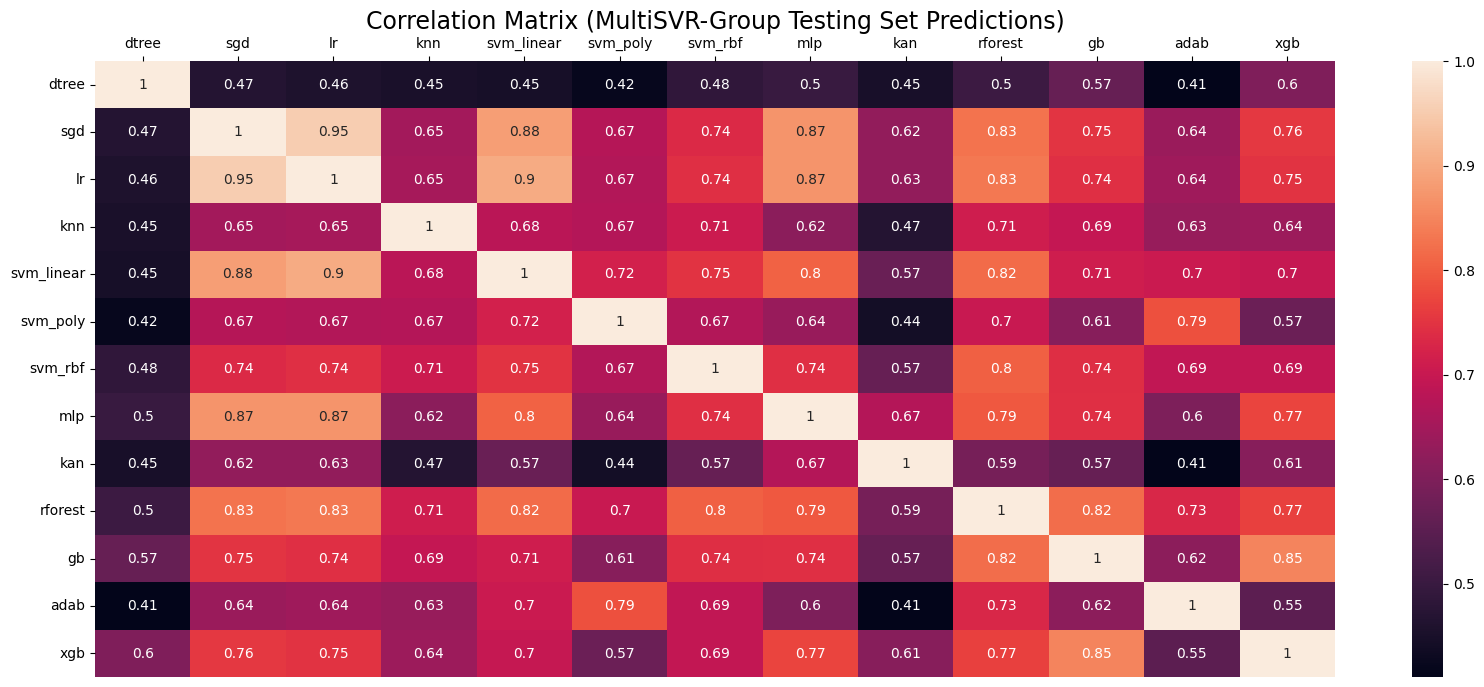

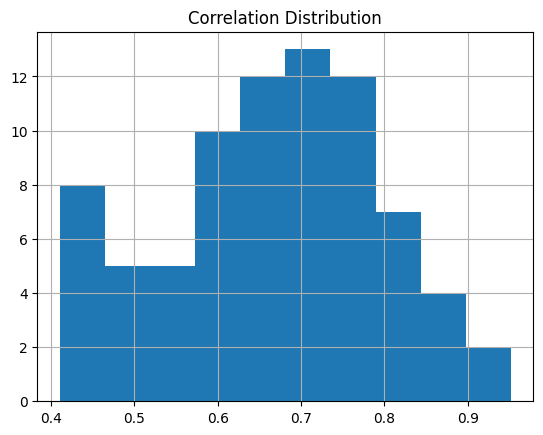

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.2743
MAE: 0.4801
NMSE: 12.5315
NMAE: 4.6119


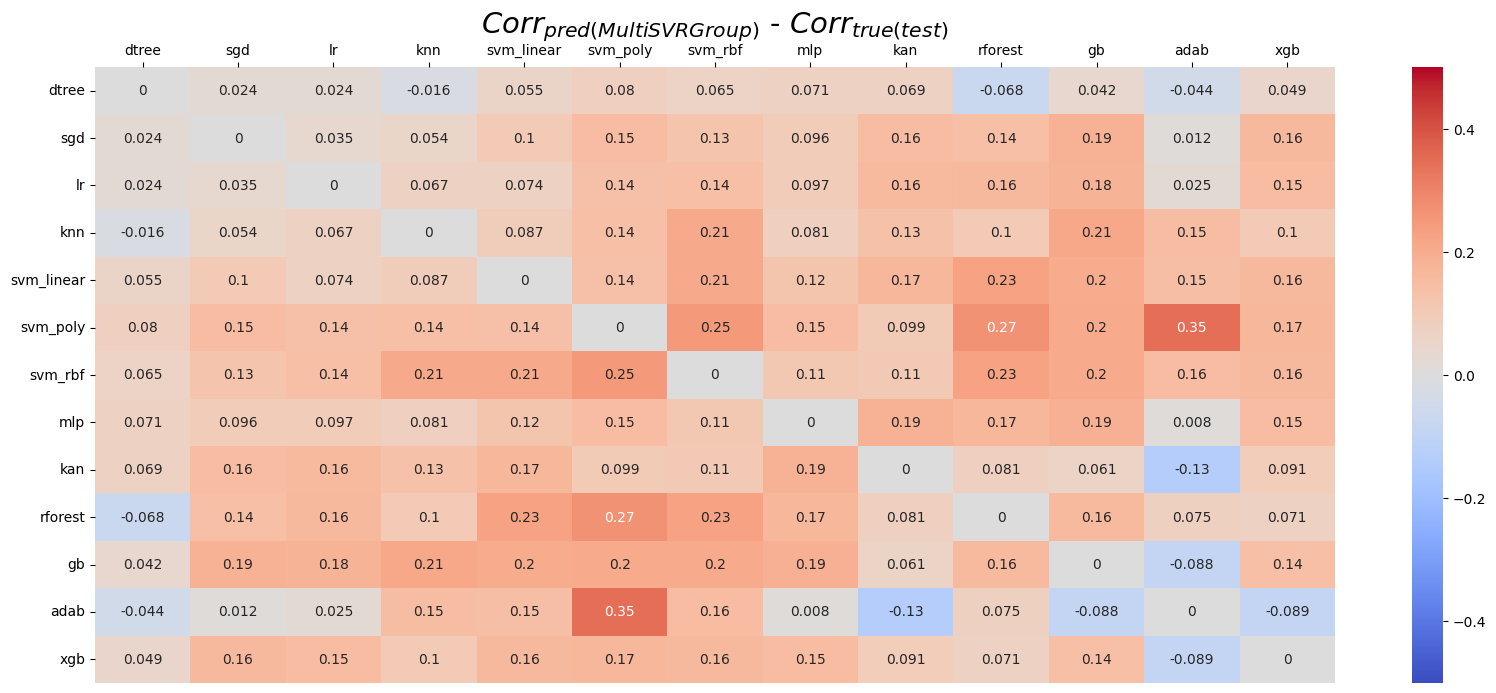

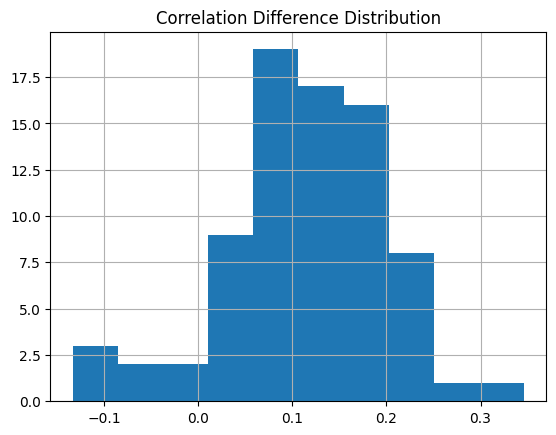

[Saved image "cm_msvrgtest.eps"]
[Saved image "cd_msvrgtest.eps"]
[Saved image "cmd_msvrg.eps"]
[Saved image "cdd_msvrg.eps"]


In [88]:
msvrGroups_corrls = y_pred.corr('kendall')
pred_corrls2 = ya_test.corr('kendall')

print(f'''MSE: {mse(ya_test, y_pred):.4f}
MAE: {mae(ya_test, y_pred):.4f}
NMSE: {nmse(ya_test, y_pred):.4f}
NMAE: {nmae(ya_test, y_pred):.4f}''')

mse_df.loc['multi-svr(group)',:] = mse(ya_test, y_pred, multioutput='raw_values')
mae_df.loc['multi-svr(group)',:] = mae(ya_test, y_pred, multioutput='raw_values')
nmse_df.loc['multi-svr(group)',:] = nmse(ya_test, y_pred, multioutput='raw_values')
nmae_df.loc['multi-svr(group)',:] = nmae(ya_test, y_pred, multioutput='raw_values')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiSVR-Group Testing Set Predictions)', fontsize=17)
hm1 = sns.heatmap(msvrGroups_corrls, annot=True)
hm1.xaxis.tick_top()
plt.show(hm)

plt.title('Correlation Distribution')
hg1 = corrlArray(msvrGroups_corrls)['corr'].hist()
plt.show(hg1)

diff_corrls = msvrGroups_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {mse(pred_corrls2, diff_corrls):.4f}
MAE: {mae(pred_corrls2, diff_corrls):.4f}
NMSE: {nmse(pred_corrls2, diff_corrls):.4f}
NMAE: {nmae(pred_corrls2, diff_corrls):.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(MultiSVRGroup)}$ - $Corr_{true(test)}$', fontsize=21)
hm2 = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm2.xaxis.tick_top()
plt.show(hm2)

plt.title('Correlation Difference Distribution')
hg2 = diff_corrls_values.hist()
plt.show(hg2)

groups['msvr_group_test'] = group_search(msvrGroups_corrls, MIN_SCORE)

save2figs(hm1, hg1, DIR)
save2figs(hm2, hg2, DIR)

### Multi-Output Random Forest

In [89]:
mrf4groups = []

for g in groups['true_assessor_train']:
    model = RandomForestRegressor(random_state=seed, n_jobs=-1).fit(Xa_train, ya_train[g])
    mrf4groups.append(model)

c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

In [90]:
%%capture
y_pred = pd.DataFrame(columns=model_names)

for i, g in enumerate(groups['true_assessor_train']):
    temp = pd.DataFrame(columns=model_names)
    temp[g] = mrf4groups[i].predict(Xa_test).reshape(-1,1) if len(g) == 1 else mrf4groups[i].predict(Xa_test)
    y_pred = pd.concat([y_pred, temp])

y_pred = y_pred.groupby(y_pred.index).aggregate('mean')

MSE: 0.0573
MAE: 0.1875
NMSE: 0.9707
NMAE: 0.9569


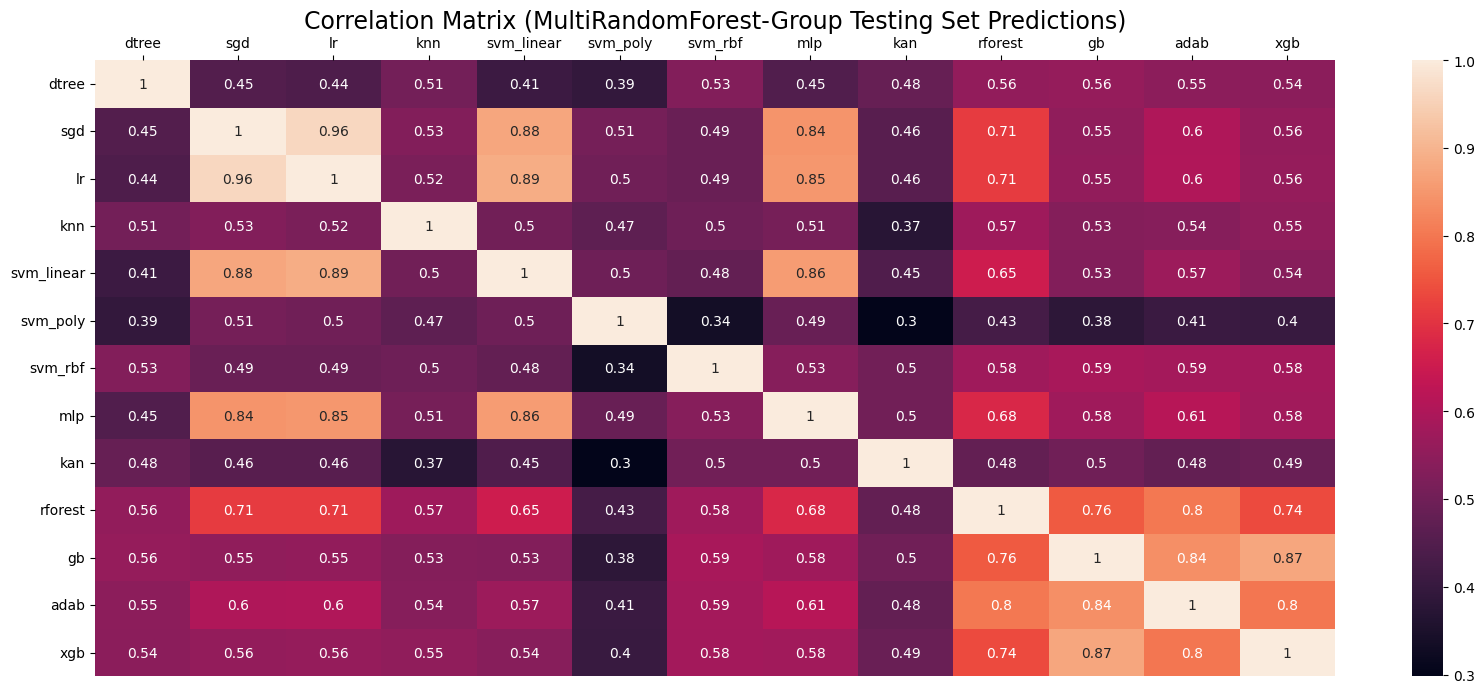

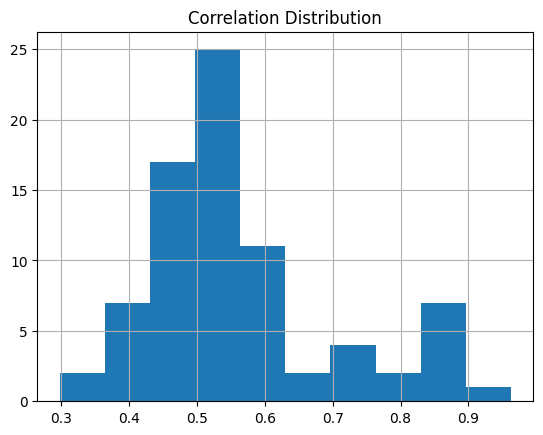

Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: 0.3566
MAE: 0.5735
NMSE: 16.2189
NMAE: 5.5136


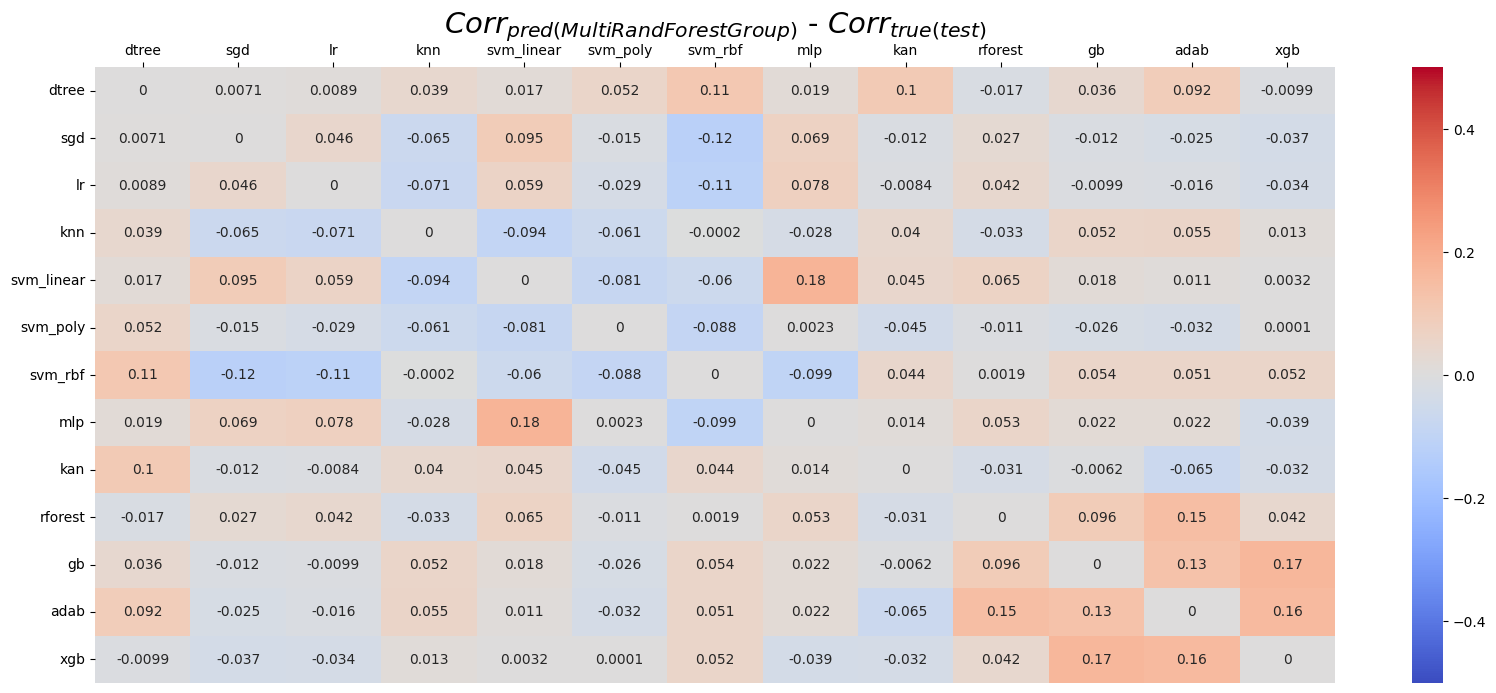

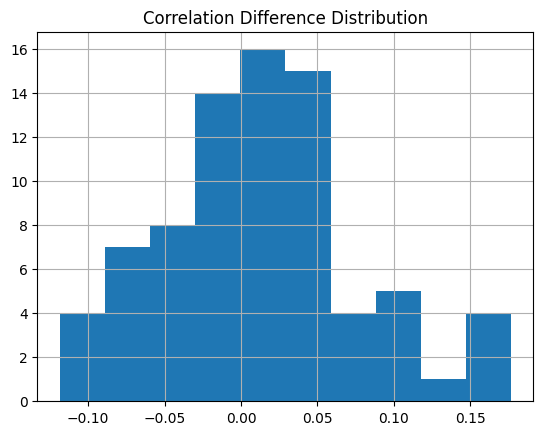

[Saved image "cm_mrfgtest.eps"]
[Saved image "cd_mrfgtest.eps"]
[Saved image "cmd_mrfg.eps"]
[Saved image "cdd_mrfg.eps"]


In [92]:
mrfGroups_corrls = y_pred.corr('kendall')
#pred_corrls2 = ya_test.corr('kendall')

print(f'''MSE: {mse(ya_test, y_pred):.4f}
MAE: {mae(ya_test, y_pred):.4f}
NMSE: {nmse(ya_test, y_pred):.4f}
NMAE: {nmae(ya_test, y_pred):.4f}''')

mse_df.loc['multi-rforest(group)',:] = mse(ya_test, y_pred, multioutput='raw_values')
mae_df.loc['multi-rforest(group)',:] = mae(ya_test, y_pred, multioutput='raw_values')
nmse_df.loc['multi-rforest(group)',:] = nmse(ya_test, y_pred, multioutput='raw_values')
nmae_df.loc['multi-rforest(group)',:] = nmae(ya_test, y_pred, multioutput='raw_values')

plt.figure(figsize=(20,8))
plt.title('Correlation Matrix (MultiRandomForest-Group Testing Set Predictions)', fontsize=17)
hm1 = sns.heatmap(mrfGroups_corrls, annot=True)
hm1.xaxis.tick_top()
plt.show(hm1)

plt.title('Correlation Distribution')
hg1 = corrlArray(mrfGroups_corrls)['corr'].hist()
plt.show(hg1)

diff_corrls = mrfGroups_corrls - pred_corrls2

diff_corrls_values = corrlArray(diff_corrls)['corr']

print(F'''Diferença entre correlações das previsões do assessor e do conjunto de teste:
MSE: {mse(pred_corrls2, diff_corrls):.4f}
MAE: {mae(pred_corrls2, diff_corrls):.4f}
NMSE: {nmse(pred_corrls2, diff_corrls):.4f}
NMAE: {nmae(pred_corrls2, diff_corrls):.4f}''')

plt.figure(figsize=(20,8))
plt.title(r'$Corr_{pred(MultiRandForestGroup)}$ - $Corr_{true(test)}$', fontsize=21)
hm2 = sns.heatmap(diff_corrls, annot=True, cmap='coolwarm', vmin=-0.5, vmax=0.5)
hm2.xaxis.tick_top()
plt.show(hm2)

plt.title('Correlation Difference Distribution')
hg2 = diff_corrls_values.hist()
plt.show(hg2)

groups['mrf_group_test'] = group_search(msvrGroups_corrls, MIN_SCORE)

save2figs(hm1, hg1, DIR)
save2figs(hm2, hg2, DIR)

In [93]:
keys = list(groups.keys())
OBJV = len(groups['true_assessor_test'])
for i in range(len(keys)):
    if('test' in keys[i] and keys[i] != 'true_assessor_test'):
        print(f'{keys[i]}({len(groups[keys[i]])}) & true_assessor_test({OBJV}):')
        count = 0
        for g in groups[keys[i]]:
            if(g in groups['true_assessor_test']):
                print(g)
                count += 1
        print(f'Número de grupos em comum: {count}\n\n')

regchain_assessor_test(10) & true_assessor_test(9):
['knn']
['dtree']
['svm_poly']
['kan']
['svm_rbf']
Número de grupos em comum: 5


mrf_assessor_test(3) & true_assessor_test(9):
Número de grupos em comum: 0


msvr_assessor_test(5) & true_assessor_test(9):
Número de grupos em comum: 0


mor_assessor_test(10) & true_assessor_test(9):
['knn']
['dtree']
['svm_poly']
['kan']
['svm_rbf']
Número de grupos em comum: 5


regchain_group_test(9) & true_assessor_test(9):
['sgd', 'mlp', 'lr', 'svm_linear']
['knn']
['dtree']
['svm_poly']
['kan']
['svm_rbf']
Número de grupos em comum: 6


msvr_group_test(6) & true_assessor_test(9):
['dtree']
Número de grupos em comum: 1


mrf_group_test(6) & true_assessor_test(9):
['dtree']
Número de grupos em comum: 1




## Análises

In [94]:
metrics_df = metricsFormat(mse_df, 'MSE')

metrics_df = pd.merge(metrics_df, metricsFormat(mae_df, 'MAE'), how='inner', on=['assessor_type', 'model'])

metrics_df = pd.merge(metrics_df, metricsFormat(nmse_df, 'NMSE'), how='inner', on=['assessor_type', 'model'])

metrics_df = pd.merge(metrics_df, metricsFormat(nmae_df, 'NMAE'), how='inner', on=['assessor_type', 'model'])

metrics_df

assessor_type  model       MSE       MAE      NMSE      NMAE
0               regchain  dtree  0.102780  0.277700  0.990281  0.991227
1          multi-rforest  dtree  0.105173  0.280676  1.013345  1.001852
2              multi-svr  dtree  0.114698  0.280551  1.105120  1.001403
3           multi-output  dtree  0.102780  0.277700  0.990281  0.991227
4        regchain(group)  dtree  0.102780  0.277700  0.990281  0.991227
..                   ...    ...       ...       ...       ...       ...
86             multi-svr    xgb  0.102871  0.253815  1.023266  0.905941
87          multi-output    xgb  0.100638  0.270314  1.001059  0.964833
88       regchain(group)    xgb  0.100638  0.270314  1.001059  0.964833
89      multi-svr(group)    xgb  0.099953  0.254911  0.994241  0.909854
90  multi-rforest(group)    xgb  0.098952  0.266019  0.984282  0.949501

[91 rows x 6 columns]

In [95]:
teste = metrics_df.drop(columns=['model']).groupby(['assessor_type']).agg(['mean', 'std'])
teste.to_csv(f'data/{DIR}/results.csv')
teste

MSE                 MAE                NMSE  \
                          mean       std      mean       std      mean   
assessor_type                                                            
multi-output          0.057202  0.040854  0.187265  0.079895  0.964853   
multi-rforest         0.057263  0.039777  0.189590  0.079440  0.973658   
multi-rforest(group)  0.057342  0.040677  0.187518  0.079249  0.970655   
multi-svr             0.062982  0.039760  0.188816  0.069356  1.332108   
multi-svr(group)      0.064157  0.041004  0.189717  0.063341  1.395430   
regchain              0.057715  0.041054  0.187591  0.080436  0.975050   
regchain(group)       0.057349  0.040964  0.186599  0.079523  0.971335   

                                    NMAE            
                           std      mean       std  
assessor_type                                       
multi-output          0.072309  0.953847  0.040632  
multi-rforest         0.053496  0.968107  0.032879  
multi-rforest(group)  0.067693  0.956941  0.036741  
multi-svr             0.887832  1.025929  0.250437  
multi-svr(group)      1.043132  1.047656  0.289977  
regchain              0.066871  0.955492  0.041613  
regchain(group)       0.075352  0.953668  0.041813

In [97]:
class_palette = sns.color_palette()[:7]

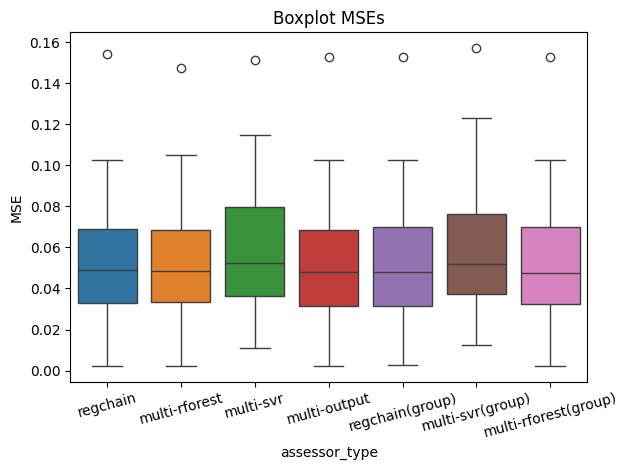

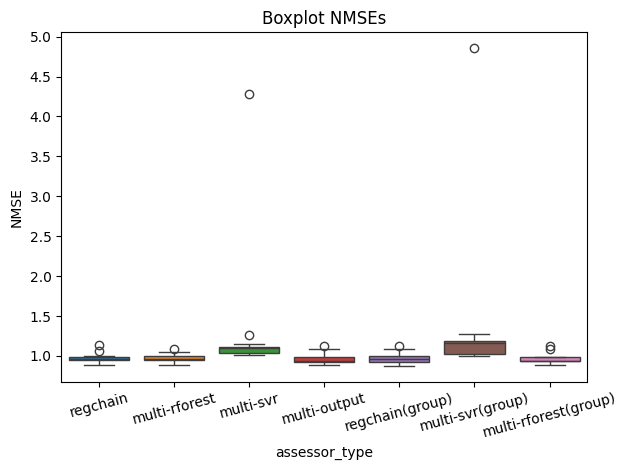

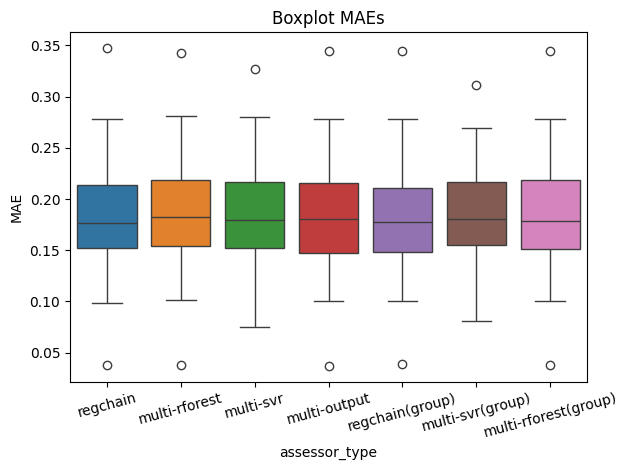

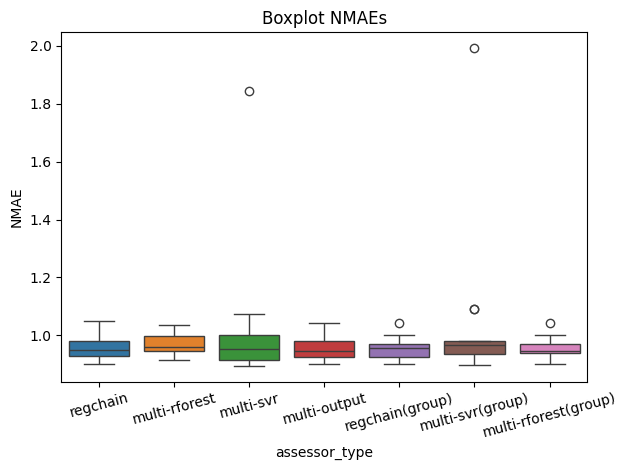

In [98]:
for mt in ['MSE', 'NMSE', 'MAE', 'NMAE']:
    plt.title(f'Boxplot {mt}s')
    imgplt = sns.boxplot(metrics_df.loc[:,['assessor_type','model',mt]], y=mt, x='assessor_type', hue='assessor_type', palette=class_palette)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show(imgplt)
    imgplt.figure.savefig(f'data/{DIR}/imgs/bp_{mt.lower()}.eps', format='eps', dpi=300)

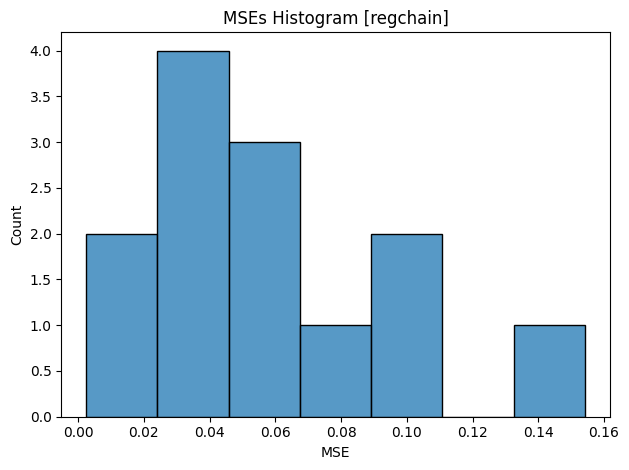

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


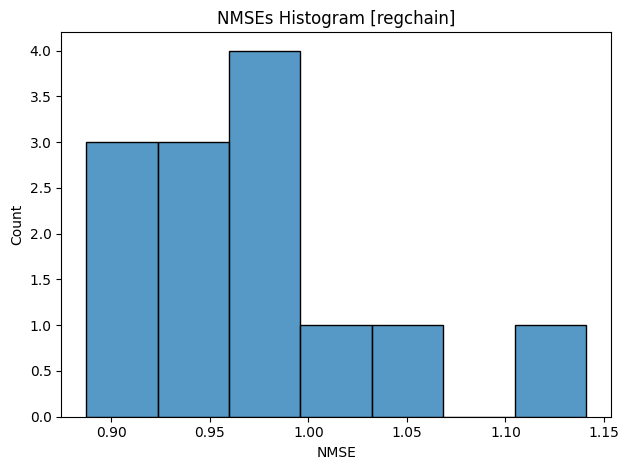

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


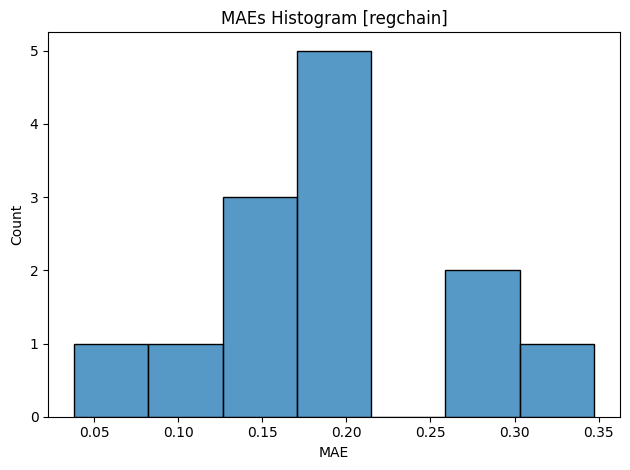

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


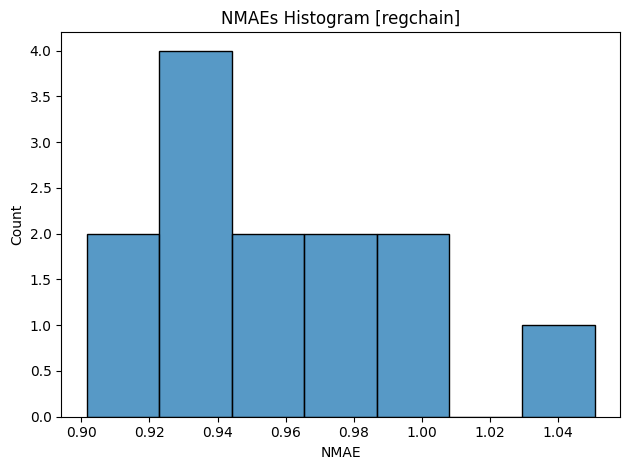

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


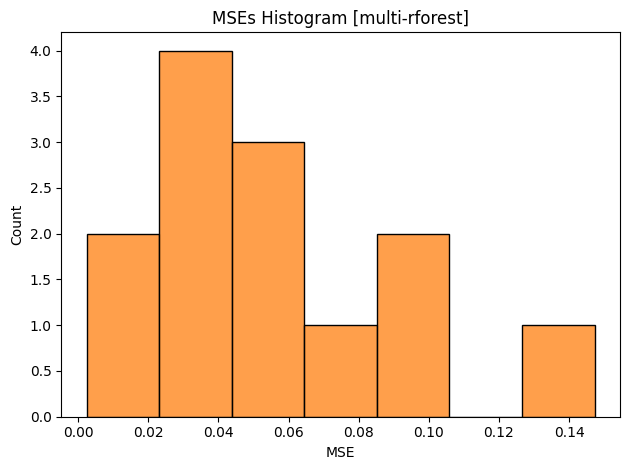

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


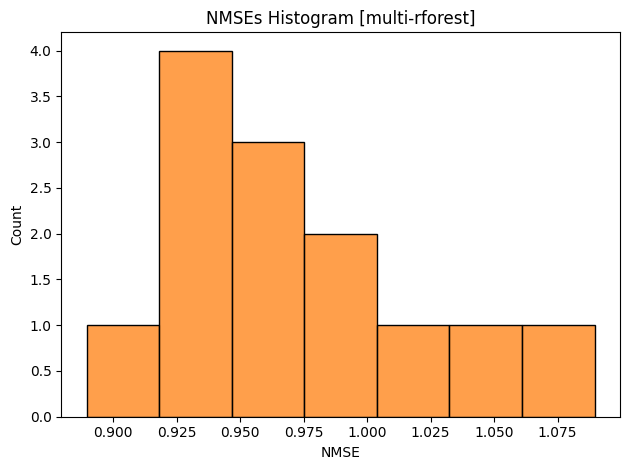

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


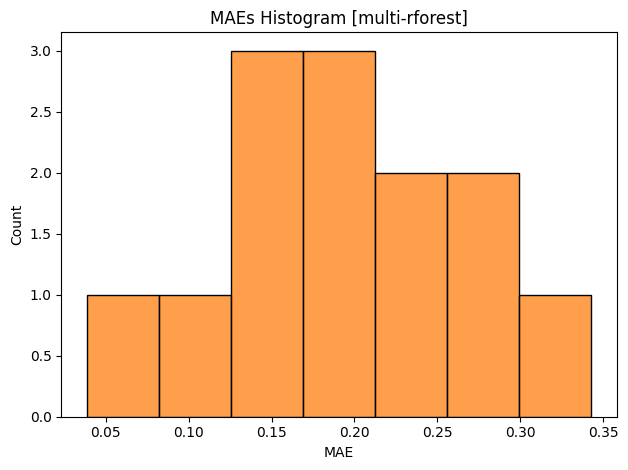

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


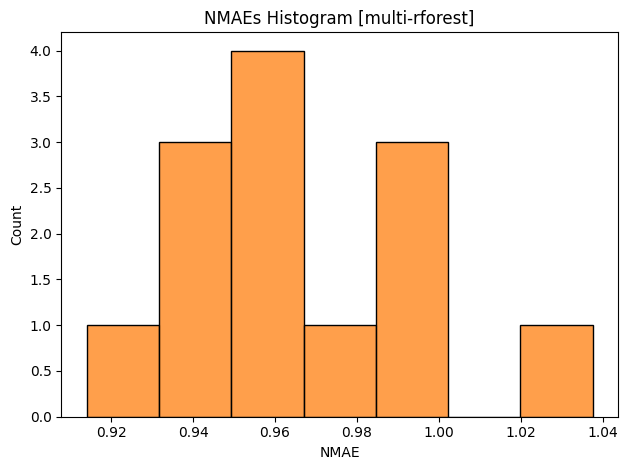

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


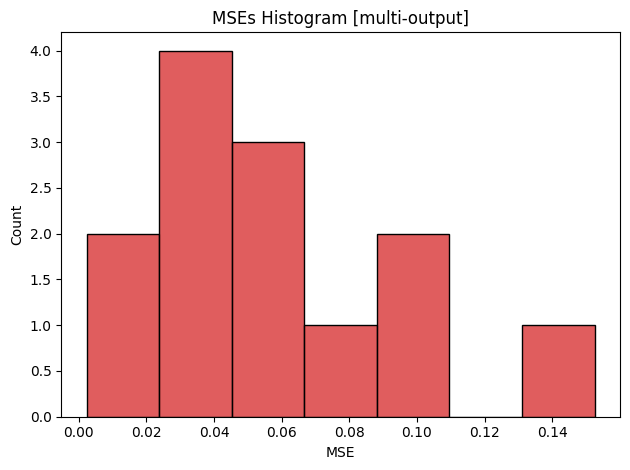

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


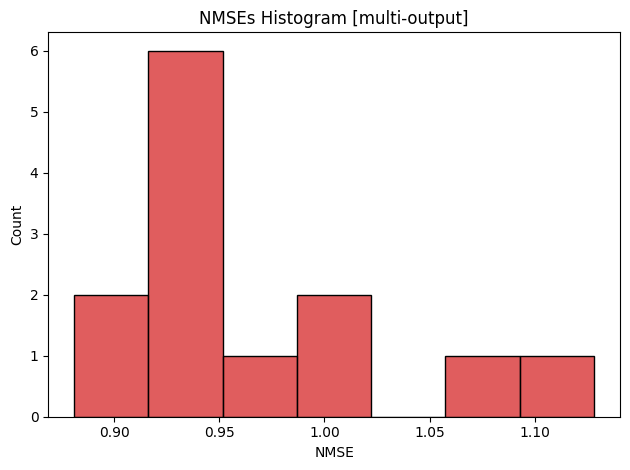

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


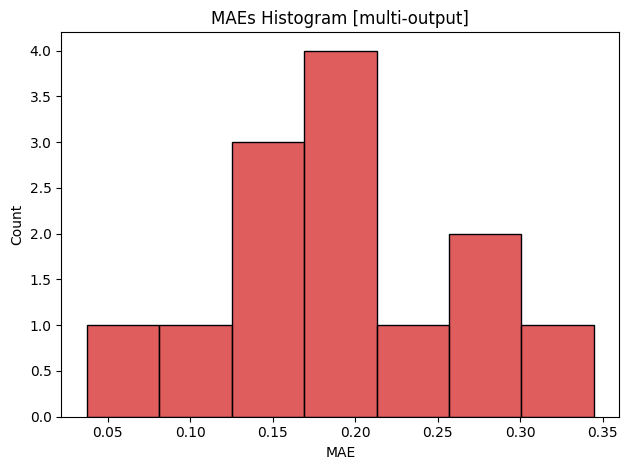

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


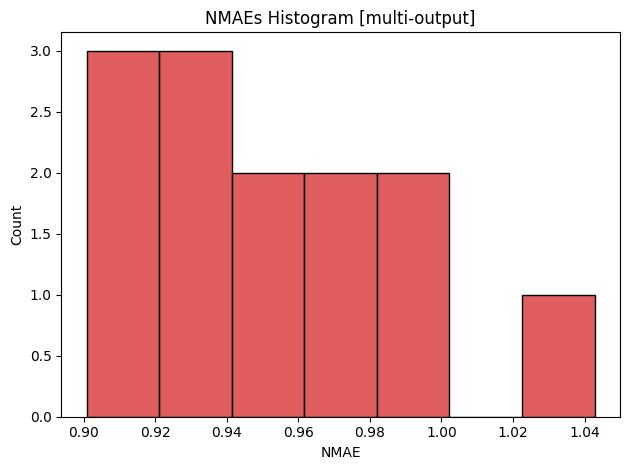

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


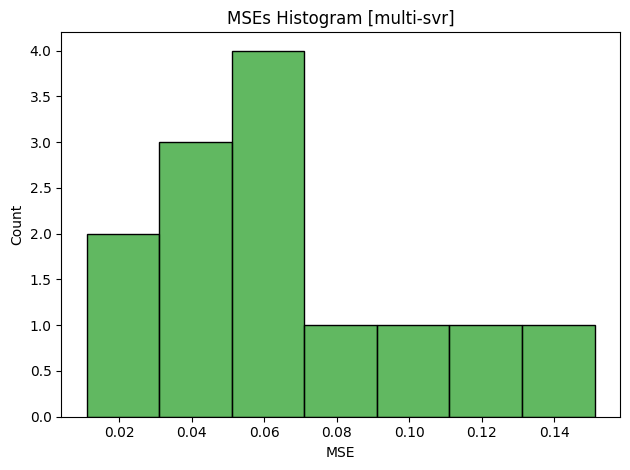

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


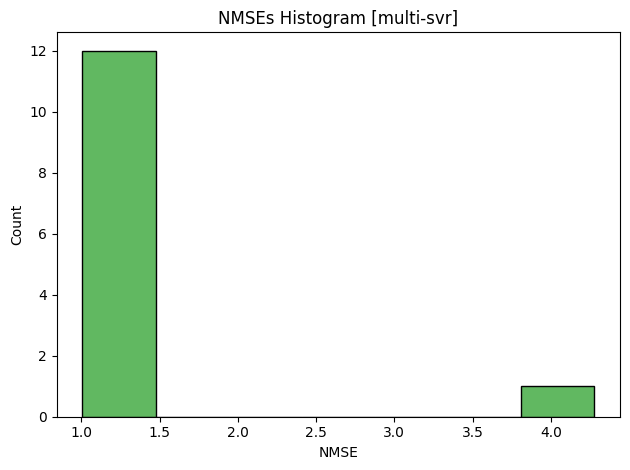

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


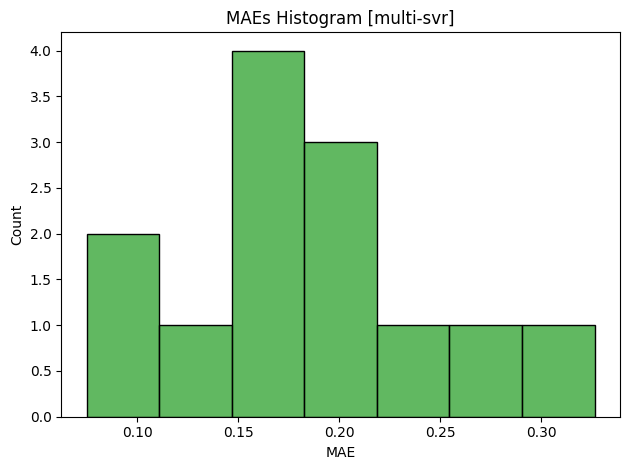

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


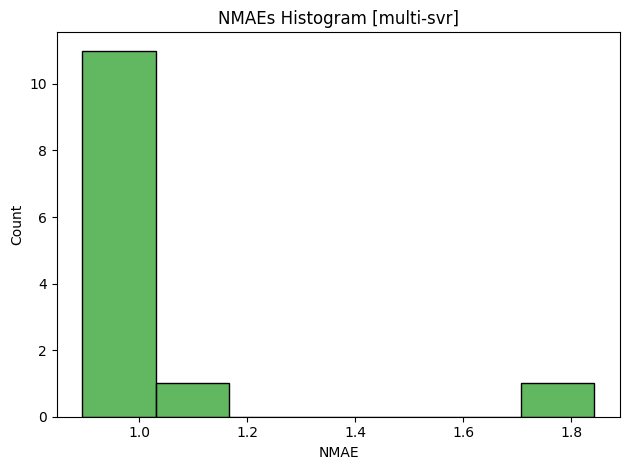

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


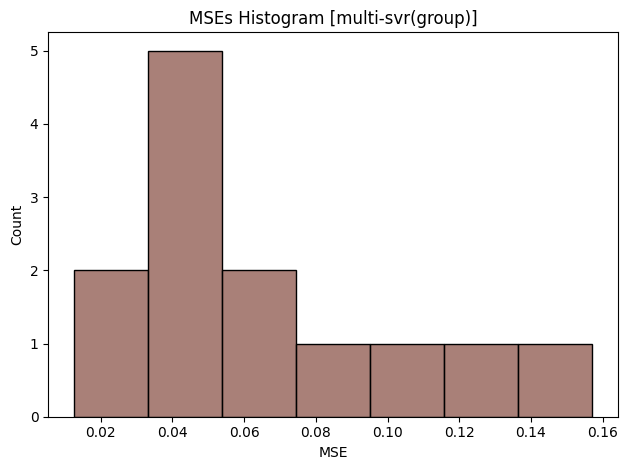

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


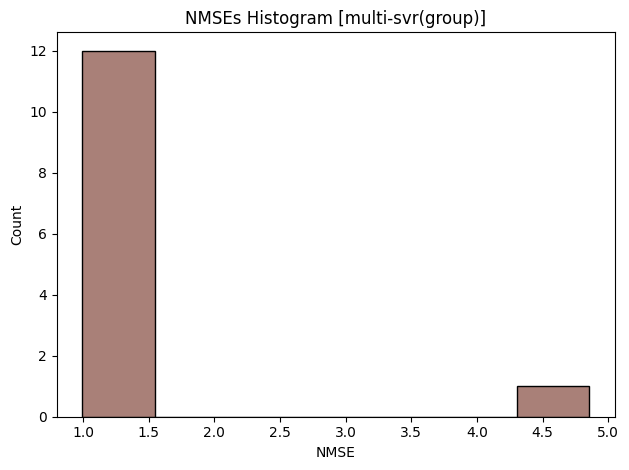

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


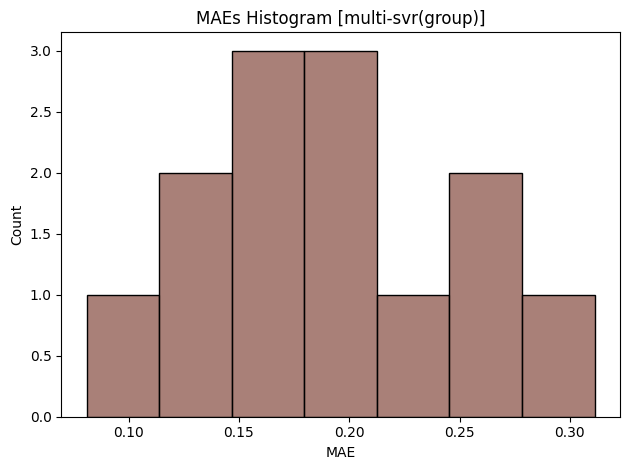

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


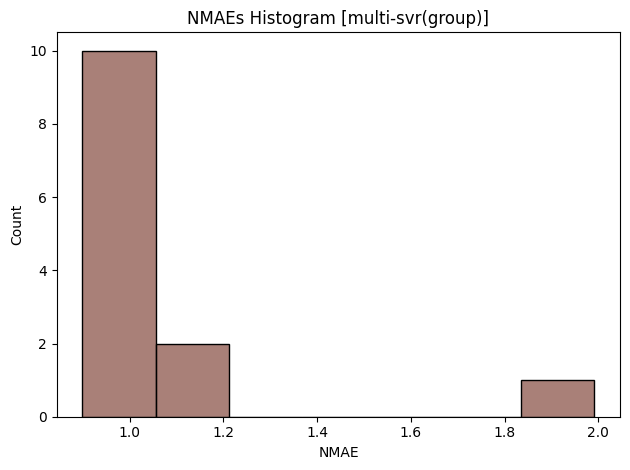

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


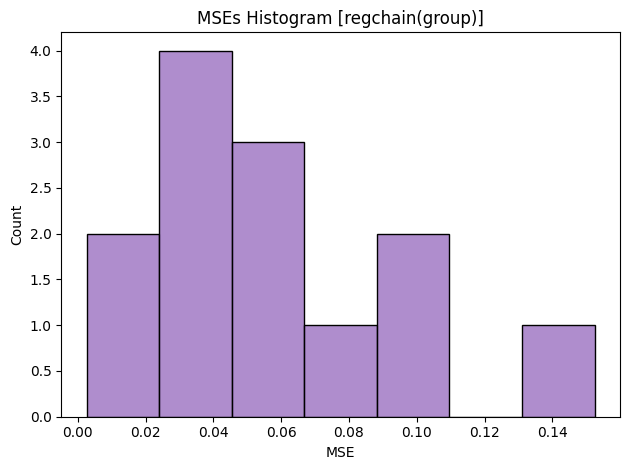

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


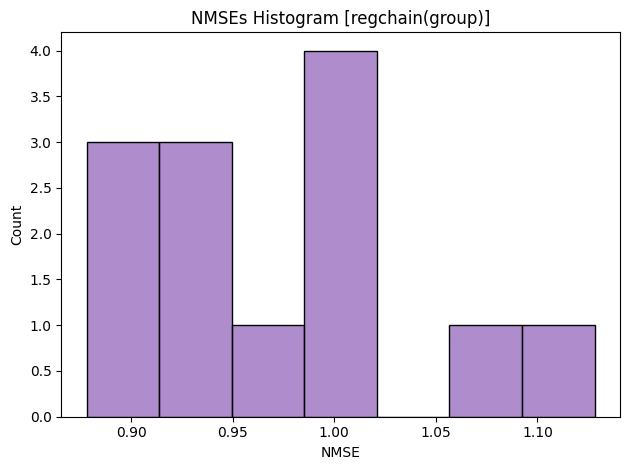

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


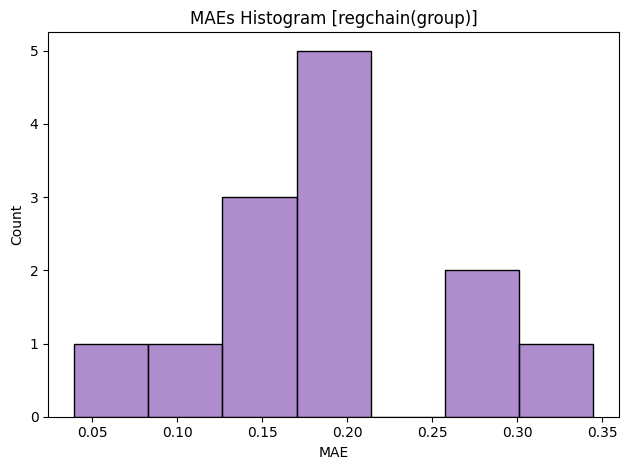

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


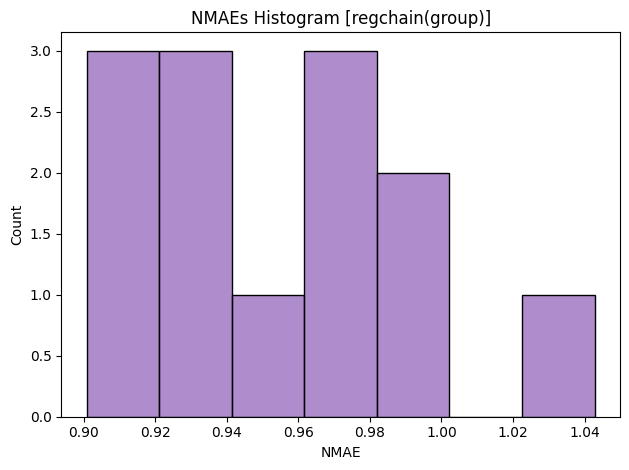

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


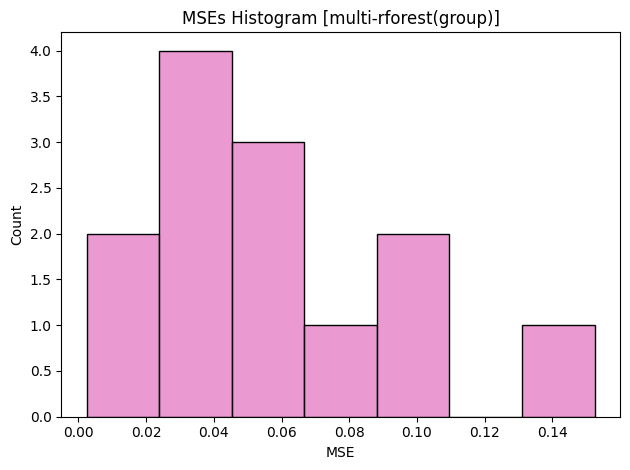

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


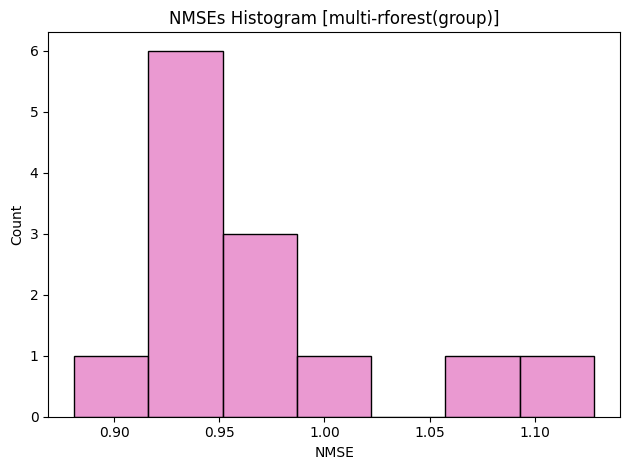

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


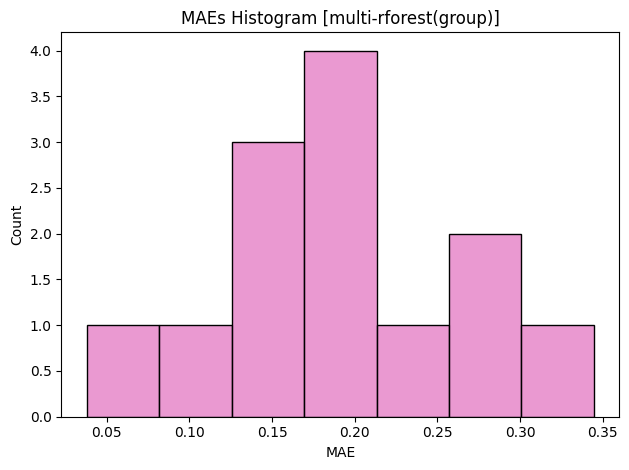

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


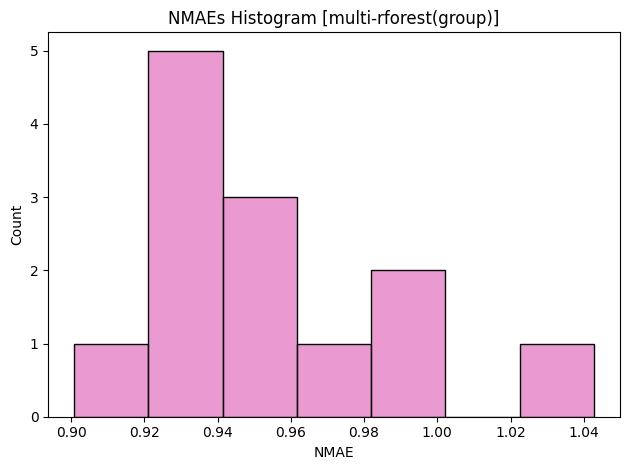

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [99]:
dicio = {'regchain': {'color': class_palette[0], 'code': 'rc'},
         'multi-rforest': {'color': class_palette[1], 'code': 'mrf'},
         'multi-output': {'color': class_palette[3], 'code': 'mor'},
         'multi-svr': {'color': class_palette[2], 'code': 'msvr'},
         'multi-svr(group)': {'color': class_palette[-2], 'code': 'msvrg'},
         'regchain(group)': {'color': class_palette[-3], 'code': 'rcg'},
         'multi-rforest(group)': {'color': class_palette[-1], 'code': 'mrfg'}}

for a in dicio.keys():
    for mt in ['MSE', 'NMSE', 'MAE', 'NMAE']:
        plt.title(f'{mt}s Histogram [{a}]')
        imgplt = sns.histplot(metrics_df.loc[metrics_df['assessor_type']==a,['assessor_type','model',mt]], x=mt, bins=7, color=dicio[a]['color'])
        plt.tight_layout()
        plt.show(imgplt)
        imgplt.figure.savefig(f'data/{DIR}/imgs/hg_{dicio[a]["code"]}_{mt.lower()}.eps', format='eps', dpi=300)

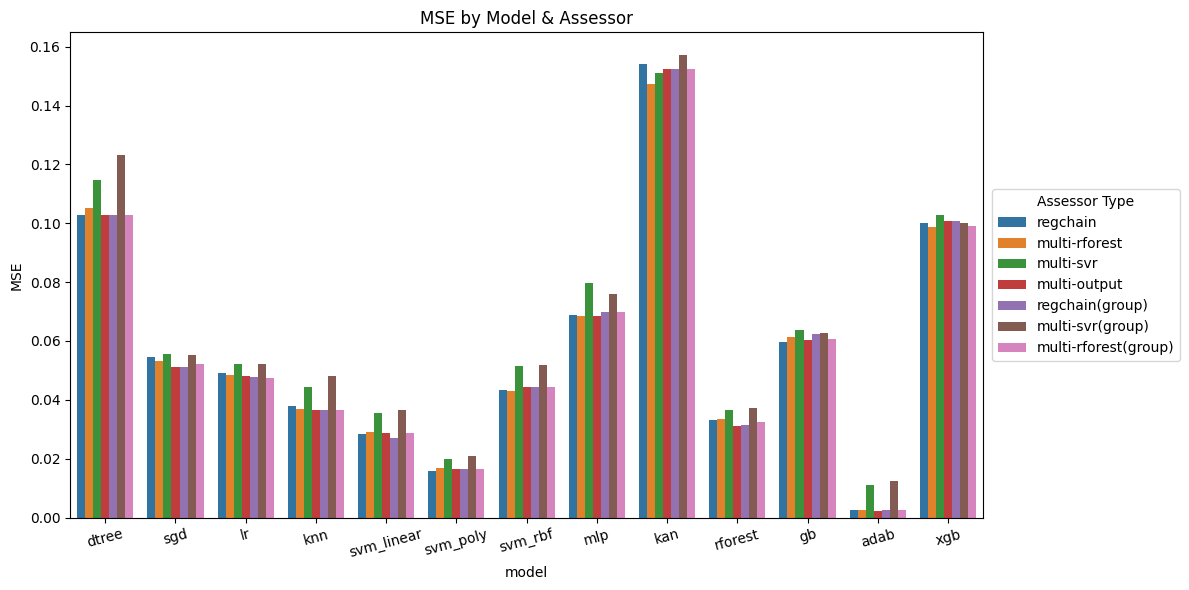

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


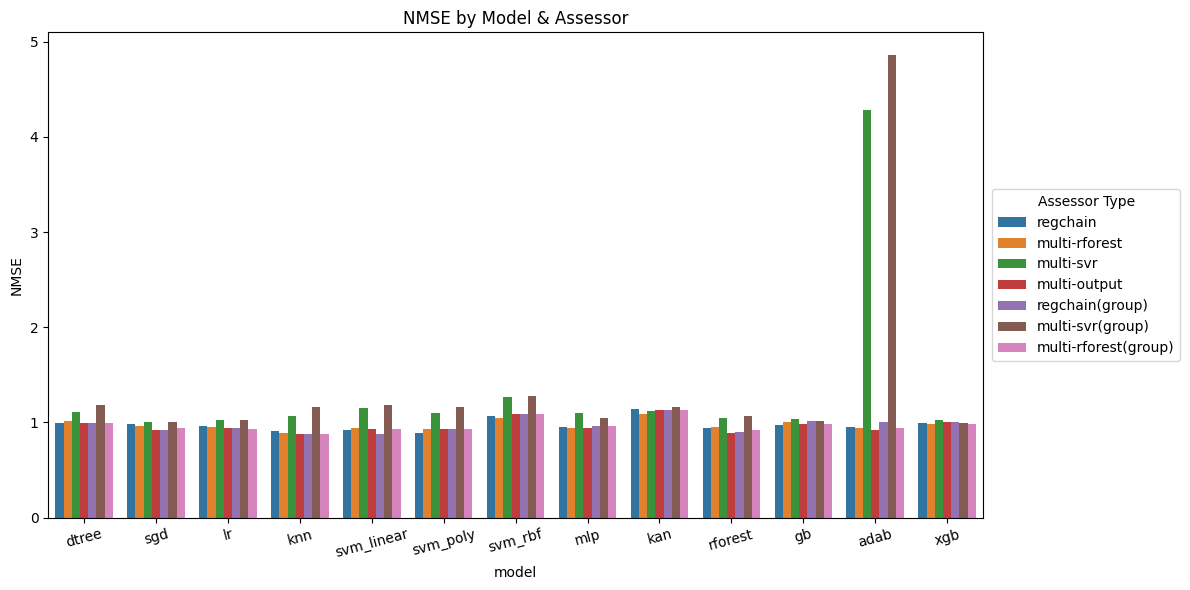

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


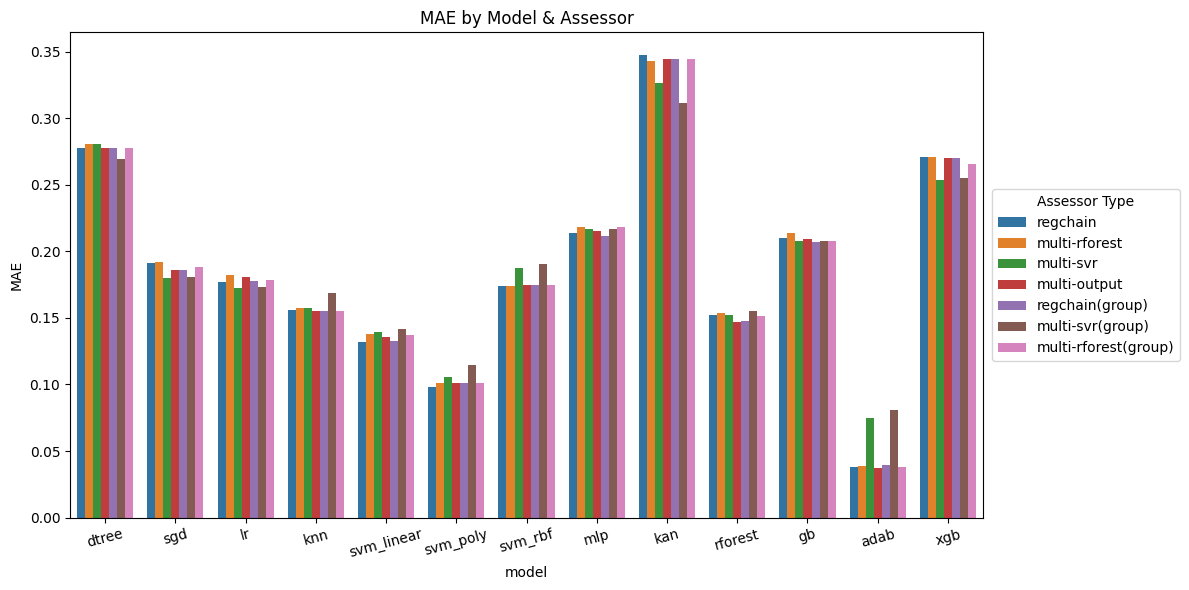

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


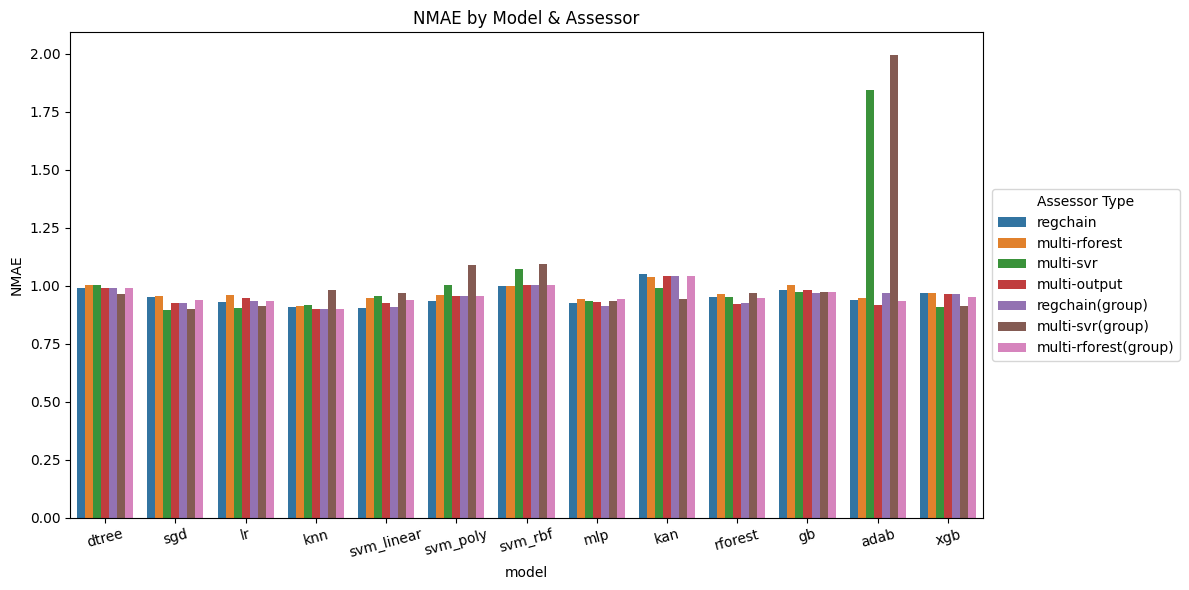

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [100]:
for mt in ['MSE', 'NMSE', 'MAE', 'NMAE']:
    plt.figure(figsize=(12, 6))
    imgplt = sns.barplot(data=metrics_df, x='model', y=mt, hue='assessor_type', palette=class_palette)
    plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', borderaxespad=0, title='Assessor Type')
    plt.title(f'{mt} by Model & Assessor')
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show(imgplt)
    imgplt.figure.savefig(f'data/{DIR}/imgs/bar_{mt.lower()}.eps', format='eps', dpi=300)